# UVXY Predictor using an adaBoost Model
Much less stable than VIXM

In [1]:
# Import appropriate modules

import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import datetime
import numpy as np
import yfinance as yf
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from vix_functions import garch_fit_and_predict, correlation_filter, retrieve_yahoo_close, retrieve_yahoo_volume

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# CONTROL PANEL

In [224]:
# Key parameters of the model

# Min return to set up a positive signal
threshold= 0.00 

# Split of data
training_period_months = 94

# Adaboost parameters
adaboost_estimators = 16
learning_rate_adaboost = 1.9
max_depth=4


# Inclusion of the first 4 components lag1
#n: number of components to include
number_of_pca_lag_component_to_include = 4
num_pca_components = 40


# Definition of demo mode or development mode
demo_mode = False
parameter_tuning_mode = True
run_multiple_tuning_iterations = True

#Dates
start_date='2011-10-05'
today=datetime.today().date()
end_date=(today+DateOffset(days=-1)).date()
start_date_volatilities=(pd.to_datetime(start_date)+DateOffset(days=-364)).date()

print(f"start date: {start_date}, end date: {end_date}, start date volatilities: {start_date_volatilities}")

start date: 2011-10-05, end date: 2021-11-20, start date volatilities: 2010-10-06


# Generation of the Features Matrix X

### X1: close prices
#### 40 units: 
    * Close prices of international indexes of stocks and bonds, 
    * key stocks, 
    * currency exchange rates, 
    * commodities 

In [225]:
# Ticker List: VIX must be in first position
# ticker_list_ORIGINAL= ["^VIX", "spy", 'XLF', 'XLE',
#               'EURUSD=X', 'GBPUSD=X', 'AUDUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
#               '^TNX', 'ZB=F', 'ZF=F', 'NQ=F','NKD=F',                                       
#               'LQD',
#               'AAPL', 'AMZN', 'GE','MU','MSFT', 'BMY', 'FDX', 'GS','PLD','NVDA',   
#               "tlt", "ief", 
#               "FXI", "EZU", "EEM", "EFA", 'FEZ', "^GDAXI", '^FTSE','^HSI','^FCHI',              #'^GSPC',
#               "gld", "slv", "CL=F"]

ticker_list= ["UVXY","^VIX", "spy", 
               'GBPUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
              '^TNX', 'ZF=F', 'NQ=F','NKD=F',                                       
              'LQD',
              'AAPL', 'AMZN','MU','MSFT', 'BMY', 'PLD', 
              "FXI", 'FEZ', '^FTSE','^FCHI','^GSPC',
              "gld", "slv", 
              "ES=F","QM=F", "BIO=F"
             ]



    
# Some of the less familiar tickers are listed below
# CAC 40 (^FCHI)
# Yen Denominated TOPIX Futures,D (TPY=F)
# FTSE 100 (^FTSE)
# SPDR EURO STOXX 50 ETF (FEZ)
# DAX PERFORMANCE-INDEX (^GDAXI)
# S&P500 Index (^GSPC)
# HANG SENG INDEX (^HSI)
# 13 Week Treasury Bill (^IRX) --eliminate
# Nikkei/USD Futures,Dec-2021 (NKD=F)
# iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD)
# Nasdaq 100 Dec 21 (NQ=F)
# NVIDIA Corporation (NVDA)
# Euro spot  'EURUSD'
# American Funds U.S. Government Securities Fund Class C (UGSCX) - 2001
# Micron Technology, Inc. (MU)
# Microsoft Corporation (MSFT)
# Bristol-Myers Squibb Company (BMY)
# FEDEX CORP (FDX)
# The Goldman Sachs Group, Inc. (GS)
# Prologis, Inc. (PLD)
# Treasury Yield 10 Years (^TNX) -- 1985
# Energy Select Sector SPDR Fund (XLE)
# Financial Select Sector SPDR Fund (XLF)
# U.S. Treasury Bond Futures,Dec- (ZB=F) - 2000
# Five-Year US Treasury Note Futu (ZF=F) - 2000
# E-Mini S&P500 (ES=F)
# E-Mini oil (QM=F)
# E-MinI Nasdaq (BIO=F)
print(f"Current number of tickers: {len(ticker_list)}")


Current number of tickers: 28


In [226]:
# X1: Upload of data using API
def retrieve_close(close_prices_dict, ticker_list):
    """
    This function retrieves close prices from Yahoo Finance
    
    Arg:
    close_prices_dict: empty dictionary to be filled with the close prices
    ticker_list: a list of tickers of the yahoo close prices to be retrieve
    
    Return:
    A dictionary with close prices
    """
    
    
    for ticker in ticker_list:
        close_price = retrieve_yahoo_close(ticker, start_date=start_date, end_date=end_date)
        close_prices_dict[ticker] = close_price
    return close_prices_dict


if demo_mode == True:
    close_prices_df = pd.read_csv("adaboost_close_prices.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    close_prices_dict = {}
    close_prices_dict = retrieve_close(close_prices_dict, ticker_list)
    close_prices_df_raw= pd.DataFrame(close_prices_dict)
    close_prices_df_raw.to_csv("adaboost_close_prices.csv", index=True)
print("Completed retrieve of close prices")

Processing Close UVXY
Processing Close ^VIX
Processing Close spy
Processing Close GBPUSD=X
Processing Close BRLUSD=X
Processing Close DX-Y.NYB
Processing Close USDJPY=X
Processing Close ^TNX
Processing Close ZF=F
Processing Close NQ=F
Processing Close NKD=F
Processing Close LQD
Processing Close AAPL
Processing Close AMZN
Processing Close MU
Processing Close MSFT
Processing Close BMY
Processing Close PLD
Processing Close FXI
Processing Close FEZ
Processing Close ^FTSE
Processing Close ^FCHI
Processing Close ^GSPC
Processing Close gld
Processing Close slv
Processing Close ES=F
Processing Close QM=F
Processing Close BIO=F
Completed retrieve of close prices


In [227]:
# X1 Fill of missing values
close_prices_df=close_prices_df_raw.ffill(axis='rows')
close_prices_df=close_prices_df_raw.bfill(axis='rows')

#RENAME COLUMN FROM UVXY TO VIXM SO WE DON'T NEED TO CHANGE THE REST OF THE PROGRAM
close_prices_df=close_prices_df.rename(columns={'UVXY':'VIXM'})

# Apply correlation filter to keep just series with some minimum level of correlation of 0.2
close_prices_component_df = correlation_filter(close_prices_df, min_corr=0.20, key_column='VIXM', eliminate_first_column=True)

# First columns is not given back, so we take opportunity to rename them
X1=close_prices_component_df

vixm=close_prices_df['VIXM']
vixm_ret=close_prices_df['VIXM'].pct_change()

#vixm=close_prices_df['VIXM']
#vixm_ret=close_prices_df['VIXM'].pct_change()
## #VIXM=pd.DataFrame([vixm, vixm_ret]).T      
## #VIXM.columns=['VIXM','VIXM_ret'

vixm=pd.DataFrame([vixm]).T
vixm.columns=['VIXM']

vixm_ret=pd.DataFrame([vixm_ret]).T
vixm_ret.columns=['VIXM_ret']



X1_no_suffix=pd.concat([vixm,close_prices_component_df], axis=1)

X1=X1_no_suffix.add_suffix("_close")

print("Completed inclusion of close prices")
X1.head()

Completed inclusion of close prices


VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  \
Date                                                              
2011-10-05  1.813800e+09   37.810001  94.211121        1.547030   
2011-10-06  1.740000e+09   36.270000  95.915512        1.546599   
2011-10-07  1.765200e+09   36.200001  95.273293        1.543448   
2011-10-10  1.559400e+09   33.020000  98.459763        1.553302   
2011-10-11  1.506000e+09   32.860001  98.558548        1.565827   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  \
Date                                                                     
2011-10-05        0.540511       78.910004       76.760002     2167.50   
2011-10-06        0.545345       78.529999       76.781998     2204.75   
2011-10-07        0.553495       78.720001       76.657997     2201.75   
2011-10-10        0.567440       77.599998       76.769997     2276.75   
2011-10-11        0.572443       77.580002       76.660004     2288.50   

            NKD=F_close  LQD_close  ...  FXI_close  FEZ_close  ^FTSE_close  \
Date                                ...                                      
2011-10-05       8525.0  79.972176  ...  24.263931  21.397181  5102.200195   
2011-10-06       8605.0  79.649681  ...  24.608326  22.137823  5291.299805   
2011-10-07       8620.0  79.578011  ...  24.295244  21.982283  5303.399902   
2011-10-10       8795.0  79.728500  ...  25.586706  23.145092  5399.000000   
2011-10-11       8760.0  79.943504  ...  26.142433  23.122869  5395.700195   

            ^FCHI_close  ^GSPC_close   gld_close  slv_close  ES=F_close  \
Date                                                                      
2011-10-05  2973.899902  1144.030029  159.460007  29.660000      1135.0   
2011-10-06  3075.370117  1164.969971  160.490005  31.200001      1157.5   
2011-10-07  3095.560059  1155.459961  159.179993  30.230000      1155.0   
2011-10-10  3161.469971  1194.890015  163.270004  31.260000      1191.0   
2011-10-11  3153.520020  1195.540039  162.100006  31.379999      1189.5   

            QM=F_close  BIO=F_close  
Date                                 
2011-10-05   79.675003   975.200012  
2011-10-06   82.599998   998.700012  
2011-10-07   82.974998   977.299988  
2011-10-10   85.400002  1001.799988  
2011-10-11   85.800003   999.299988  

[5 rows x 25 columns]

In [228]:
#close_prices_df
#X1

In [229]:
# Presentation graphs of the SPY and the VIX

presentation_graph=pd.concat([X1['spy_close'], 2.5*X1['VIXM_close']],axis=1).hvplot(
        title='VIXM and S&P (Scale adjusted)',
        width=1000
)
presentation_graph

graph1=X1['spy_close'].hvplot(
                title= "SPY: iShares S&P 500 ETF Close Price",
                ylabel= 'Close Price [$]'
) 

graph2=X1['VIXM_close'].hvplot(
                color ='red',
                title ='VIXM close price',
                ylabel= '[%]'

)
display(graph1)
graph2 



:Curve   [Date]   (spy_close)

:Curve   [Date]   (VIXM_close)

### X2: returns

In [230]:
# Inclusion of security returns X2
# Include returns that are correlated more than 0.20 with the VIXM return

security_returns_df= close_prices_df.pct_change()
security_returns_component_df = correlation_filter(
                                        security_returns_df, 
                                        min_corr=0.20, 
                                        key_column='VIXM', 
                                        eliminate_first_column=False
)

X2_no_suffix=security_returns_component_df

X2=X2_no_suffix.add_suffix("_returns")

print("Completed inclusion of returns")

X2

Completed inclusion of returns


VIXM_returns  ^VIX_returns  spy_returns  ^TNX_returns  \
Date                                                                
2011-10-05           NaN           NaN          NaN           NaN   
2011-10-06     -0.040688     -0.040730     0.018091      0.042520   
2011-10-07      0.014483     -0.001930    -0.006696      0.041289   
2011-10-10     -0.116587     -0.087845     0.033446      0.003868   
2011-10-11     -0.034244     -0.004846     0.001003      0.040462   
...                  ...           ...          ...           ...   
2021-11-15     -0.019029      0.012277     0.000342      0.025917   
2021-11-16      0.004682     -0.007277     0.003958      0.006778   
2021-11-17      0.024634      0.045205    -0.002429     -0.018360   
2021-11-18      0.015595      0.028054     0.003396     -0.009352   
2021-11-19      0.019194      0.018192    -0.001788     -0.033354   

            ZF=F_returns  NQ=F_returns  NKD=F_returns  AAPL_returns  \
Date                                                                  
2011-10-05           NaN           NaN            NaN           NaN   
2011-10-06     -0.001785      0.017186       0.009384     -0.002327   
2011-10-07     -0.002874     -0.001361       0.001743     -0.020060   
2011-10-10     -0.004292      0.034064       0.020302      0.051406   
2011-10-11      0.001866      0.005161      -0.003980      0.029526   
...                  ...           ...            ...           ...   
2021-11-15     -0.000643     -0.000309       0.000336      0.000067   
2021-11-16     -0.000515      0.006981       0.003531      0.006667   
2021-11-17      0.001095      0.000659      -0.009048      0.016490   
2021-11-18      0.000579      0.010407       0.001860      0.028536   
2021-11-19      0.000643      0.005688       0.000169      0.016976   

            AMZN_returns  MU_returns  MSFT_returns  BMY_returns  PLD_returns  \
Date                                                                           
2011-10-05           NaN         NaN           NaN          NaN          NaN   
2011-10-06      0.009157    0.002020      0.017381     0.001543     0.054718   
2011-10-07      0.014582   -0.002016     -0.003417    -0.002157    -0.039215   
2011-10-10      0.029278    0.042424      0.026285     0.013897     0.045068   
2011-10-11      0.017984    0.007752      0.002227     0.003960    -0.004882   
...                  ...         ...           ...          ...          ...   
2021-11-15      0.005824   -0.006727     -0.001930     0.003197     0.009341   
2021-11-16     -0.001405    0.000391      0.010236    -0.008722    -0.004860   
2021-11-17      0.002344   -0.017576      0.000679     0.005753     0.006088   
2021-11-18      0.041437    0.020673      0.006340    -0.006729     0.001330   
2021-11-19     -0.005273    0.078032      0.005392    -0.020495    -0.002391   

            FXI_returns  FEZ_returns  ^FTSE_returns  ^FCHI_returns  \
Date                                                                 
2011-10-05          NaN          NaN            NaN            NaN   
2011-10-06     0.014194     0.034614       0.037062       0.034120   
2011-10-07    -0.012723    -0.007026       0.002287       0.006565   
2011-10-10     0.053157     0.052898       0.018026       0.021292   
2011-10-11     0.021719    -0.000960      -0.000611      -0.002515   
...                 ...          ...            ...            ...   
2021-11-15    -0.007484    -0.005151       0.000544       0.005250   
2021-11-16     0.012649     0.000000      -0.003387       0.003363   
2021-11-17    -0.011290     0.000207      -0.004886       0.000594   
2021-11-18    -0.021623     0.002692      -0.004828      -0.002078   
2021-11-19     0.005960    -0.016109      -0.004465      -0.004157   

            ^GSPC_returns  ES=F_returns  BIO=F_returns  
Date                                                    
2011-10-05            NaN           NaN            NaN  
2011-10-06       0.018304      0.019824       0.024098  
2011-10-07

In [231]:
#security_returns_component_df.head()
X2

VIXM_returns  ^VIX_returns  spy_returns  ^TNX_returns  \
Date                                                                
2011-10-05           NaN           NaN          NaN           NaN   
2011-10-06     -0.040688     -0.040730     0.018091      0.042520   
2011-10-07      0.014483     -0.001930    -0.006696      0.041289   
2011-10-10     -0.116587     -0.087845     0.033446      0.003868   
2011-10-11     -0.034244     -0.004846     0.001003      0.040462   
...                  ...           ...          ...           ...   
2021-11-15     -0.019029      0.012277     0.000342      0.025917   
2021-11-16      0.004682     -0.007277     0.003958      0.006778   
2021-11-17      0.024634      0.045205    -0.002429     -0.018360   
2021-11-18      0.015595      0.028054     0.003396     -0.009352   
2021-11-19      0.019194      0.018192    -0.001788     -0.033354   

            ZF=F_returns  NQ=F_returns  NKD=F_returns  AAPL_returns  \
Date                                                                  
2011-10-05           NaN           NaN            NaN           NaN   
2011-10-06     -0.001785      0.017186       0.009384     -0.002327   
2011-10-07     -0.002874     -0.001361       0.001743     -0.020060   
2011-10-10     -0.004292      0.034064       0.020302      0.051406   
2011-10-11      0.001866      0.005161      -0.003980      0.029526   
...                  ...           ...            ...           ...   
2021-11-15     -0.000643     -0.000309       0.000336      0.000067   
2021-11-16     -0.000515      0.006981       0.003531      0.006667   
2021-11-17      0.001095      0.000659      -0.009048      0.016490   
2021-11-18      0.000579      0.010407       0.001860      0.028536   
2021-11-19      0.000643      0.005688       0.000169      0.016976   

            AMZN_returns  MU_returns  MSFT_returns  BMY_returns  PLD_returns  \
Date                                                                           
2011-10-05           NaN         NaN           NaN          NaN          NaN   
2011-10-06      0.009157    0.002020      0.017381     0.001543     0.054718   
2011-10-07      0.014582   -0.002016     -0.003417    -0.002157    -0.039215   
2011-10-10      0.029278    0.042424      0.026285     0.013897     0.045068   
2011-10-11      0.017984    0.007752      0.002227     0.003960    -0.004882   
...                  ...         ...           ...          ...          ...   
2021-11-15      0.005824   -0.006727     -0.001930     0.003197     0.009341   
2021-11-16     -0.001405    0.000391      0.010236    -0.008722    -0.004860   
2021-11-17      0.002344   -0.017576      0.000679     0.005753     0.006088   
2021-11-18      0.041437    0.020673      0.006340    -0.006729     0.001330   
2021-11-19     -0.005273    0.078032      0.005392    -0.020495    -0.002391   

            FXI_returns  FEZ_returns  ^FTSE_returns  ^FCHI_returns  \
Date                                                                 
2011-10-05          NaN          NaN            NaN            NaN   
2011-10-06     0.014194     0.034614       0.037062       0.034120   
2011-10-07    -0.012723    -0.007026       0.002287       0.006565   
2011-10-10     0.053157     0.052898       0.018026       0.021292   
2011-10-11     0.021719    -0.000960      -0.000611      -0.002515   
...                 ...          ...            ...            ...   
2021-11-15    -0.007484    -0.005151       0.000544       0.005250   
2021-11-16     0.012649     0.000000      -0.003387       0.003363   
2021-11-17    -0.011290     0.000207      -0.004886       0.000594   
2021-11-18    -0.021623     0.002692      -0.004828      -0.002078   
2021-11-19     0.005960    -0.016109      -0.004465      -0.004157   

            ^GSPC_returns  ES=F_returns  BIO=F_returns  
Date                                                    
2011-10-05            NaN           NaN            NaN  
2011-10-06       0.018304      0.019824       0.024098  
2011-10-07

### X3: volume

In [232]:
# inclusion of security volume X3
volume_list = ticker_list[0:len(ticker_list)]

def retrieve_volume(volume_dict, volume_list):
    """
    This function retrieve volume trades from a list of tickers
    
    Args:
    volume_dict: an initial dictionary to populate
    volume_list: the list of tickers for which to retrieve the volume
    
    
    Return:
    The original dictionary filled with the volume of the list of tickers
    """
    for ticker in volume_list:        
        volume = retrieve_yahoo_volume(ticker, start_date=start_date, end_date=end_date)
        volume_dict[ticker] = volume
    return volume_dict

if demo_mode == True:
    volume_df = pd.read_csv("adaboost_volume.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    volume_dict = {}
    volume_dict = retrieve_volume(volume_dict, volume_list)
    volume_df= pd.DataFrame(volume_dict)
    volume_df.to_csv("adaboost_volume.csv", index=True)
print("Completed retrieve of volume")

volume_df_with_vixm=pd.concat([vixm_ret, volume_df], axis=1)
#print(volume_df_with_vixm.corr())

volume_component_df = correlation_filter(volume_df_with_vixm, min_corr=0.14, key_column='VIXM_ret', eliminate_first_column=True )
X3_no_suffix=volume_component_df

X3=X3_no_suffix.add_suffix("_volume")

Processing Volume UVXY
Processing Volume ^VIX
Processing Volume spy
Processing Volume GBPUSD=X
Processing Volume BRLUSD=X
Processing Volume DX-Y.NYB
Processing Volume USDJPY=X
Processing Volume ^TNX
Processing Volume ZF=F
Processing Volume NQ=F
Processing Volume NKD=F
Processing Volume LQD
Processing Volume AAPL
Processing Volume AMZN
Processing Volume MU
Processing Volume MSFT
Processing Volume BMY
Processing Volume PLD
Processing Volume FXI
Processing Volume FEZ
Processing Volume ^FTSE
Processing Volume ^FCHI
Processing Volume ^GSPC
Processing Volume gld
Processing Volume slv
Processing Volume ES=F
Processing Volume QM=F
Processing Volume BIO=F
Completed retrieve of volume


In [233]:
#volume_component_df
#X3
#volume_df_with_vixm

######## ADJUSTMENT FOR VIXM NAME ##########
#RENAME COLUMN FROM UVXY TO VIXM SO WE DON'T NEED TO CHANGE THE REST OF THE PROGRAM
security_returns_df=security_returns_df.rename(columns={'UVXY':'VIXM'})

ticker_list= ["VIXM","^VIX", "spy", 
               'GBPUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
              '^TNX', 'ZF=F', 'NQ=F','NKD=F',                                       
              'LQD',
              'AAPL', 'AMZN','MU','MSFT', 'BMY', 'PLD', 
              "FXI", 'FEZ', '^FTSE','^FCHI','^GSPC',
              "gld", "slv", 
              "ES=F","QM=F", "BIO=F"
             ]


### X4: GARCH Models
    * GJR-GARCH Model conditional volatility
    * Model a response to shocks
    * Allow an asymmetryc t-student distribution 

In [234]:
# Inclusion of GARCH series X4
garch_series_df=pd.DataFrame()

not_to_include=[]#['BIO=F']


for ticker in ticker_list:
    
        if ticker in not_to_include:
            continue
    
        if demo_mode == True:
            print_series = False
        else:
            print_series = True
        garch_series_df[ticker]=garch_fit_and_predict(security_returns_df[ticker], ticker, horizon=1, p=1, q=1, o=1, print_series_name=print_series)
            
        
X4_no_suffix=garch_series_df
X4=X4_no_suffix.add_suffix("_garch")

if demo_mode == False:
    X4

print('GARCH Process fit and predictions completed')


Processing series: VIXM.....
Processing series: ^VIX.....
Processing series: spy.....
Processing series: GBPUSD=X.....
Processing series: BRLUSD=X.....
Processing series: DX-Y.NYB.....
Processing series: USDJPY=X.....
Processing series: ^TNX.....
Processing series: ZF=F.....
Processing series: NQ=F.....
Processing series: NKD=F.....
Processing series: LQD.....
Processing series: AAPL.....
Processing series: AMZN.....
Processing series: MU.....
Processing series: MSFT.....
Processing series: BMY.....
Processing series: PLD.....
Processing series: FXI.....
Processing series: FEZ.....
Processing series: ^FTSE.....
Processing series: ^FCHI.....
Processing series: ^GSPC.....
Processing series: gld.....
Processing series: slv.....
Processing series: ES=F.....
Processing series: QM=F.....
Processing series: BIO=F.....
GARCH Process fit and predictions completed


/Users/Paola/Applications/anaconda3/envs/dev/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [235]:
garch_series_df
#X4

VIXM      ^VIX       spy  GBPUSD=X  BRLUSD=X  DX-Y.NYB  \
Date                                                                     
2011-10-06  0.998467  0.801960  1.524682  0.529140  1.326863  0.678035   
2011-10-07  0.885484  0.741122  1.442383  0.522063  1.308029  0.666778   
2011-10-10  0.837458  0.693727  1.315191  0.521549  1.311745  0.699580   
2011-10-11  0.750956  0.657263  1.191574  0.525829  1.285544  0.686404   
2011-10-12  0.767797  0.629531  1.082907  0.525675  1.256946  0.686532   
...              ...       ...       ...       ...       ...       ...   
2021-11-15  0.492480  0.608232  0.565394  0.543563  0.973511  0.358000   
2021-11-16  0.478040  0.592757  0.536119  0.534473  0.952377  0.366505   
2021-11-17  0.494364  0.623519  0.539668  0.525768  0.957995  0.361037   
2021-11-18  0.490604  0.617942  0.514290  0.521982  0.945230  0.359347   
2021-11-19  0.243385  0.365575  0.261046  0.263568  0.871742  0.136058   

            USDJPY=X      ^TNX      ZF=F      NQ=F  ...       FXI       FEZ  \
Date                                                ...                       
2011-10-06  0.545705  3.414472  2.138622  1.516955  ...  2.804221  2.987201   
2011-10-07  0.526968  3.380751  2.168646  1.407648  ...  2.727771  2.809242   
2011-10-10  0.508088  3.318139  2.302207  1.304675  ...  2.730508  2.798087   
2011-10-11  0.491051  3.285981  2.287560  1.211718  ...  2.645693  2.615585   
2011-10-12  0.472849  3.242009  2.227959  1.127985  ...  2.607207  2.490885   
...              ...       ...       ...       ...  ...       ...       ...   
2021-11-15  0.394318  2.899894  2.141849  0.868461  ...  1.481852  0.849413   
2021-11-16  0.383103  2.847577  2.084056  0.821177  ...  1.449576  0.815232   
2021-11-17  0.411990  2.833621  2.045381  0.779373  ...  1.452195  0.784305   
2021-11-18  0.439726  2.791618  1.993977  0.742551  ...  1.561620  0.757854   
2021-11-19  0.180492  8.224199  3.786442  0.504449  ...  2.300296  1.063817   

               ^FTSE     ^FCHI     ^GSPC       gld       slv      ES=F  \
Date                                                                     
2011-10-06  1.404773  2.073530  1.551389  1.230760  2.878278  1.528994   
2011-10-07  1.323640  1.947544  1.492864  1.216577  2.870268  1.385592   
2011-10-10  1.248303  1.829980  1.350184  1.295154  2.898402  1.307565   
2011-10-11  1.178739  1.725725  1.223442  1.277187  2.852404  1.185353   
2011-10-12  1.113945  1.623130  1.111090  1.261028  2.816449  1.076691   
...              ...       ...       ...       ...       ...       ...   
2021-11-15  0.540094  0.504104  0.574238  0.819598  1.505778  0.562035   
2021-11-16  0.550466  0.496607  0.544126  0.817251  1.497021  0.533633   
2021-11-17  0.581105  0.489940  0.548859  0.824278  1.487938  0.530114   
2021-11-18  0.605723  0.497563  0.522641  0.813809  1.474850  0.506563   
2021-11-19  0.385748  0.287435  0.262151  0.660729  2.138083  0.249190   

                QM=F     BIO=F  
Date                            
2011-10-06  0.228789  1.894496  
2011-10-07  0.212152  1.884329  
2011-10-10  0.215257  1.889884  
2011-10-11  0.200289  1.885682  
2011-10-12  0.187132  1.880474  
...              ...       ...  
2021-11-15  0.203270  1.787762  
2021-11-16  0.189474  1.788502  
2021-11-17  0.223167  1.788641  
2021-11-18  0.208253  1.787854  
2021-11-19  0.068652  3.204408  

[2642 rows x 28 columns]

### X5: Return squared


In [236]:
# Inclusion of return squares in X5

returns_squared_df= security_returns_df**2
returns_squared_and_vixm_ret_df=pd.concat([vixm_ret,returns_squared_df], axis=1)
returns_squared_and_vixm_ret_df
returns_squared_component_df = correlation_filter(returns_squared_and_vixm_ret_df, min_corr=0.20, key_column='VIXM', eliminate_first_column=True)

X5_no_suffix_df=returns_squared_component_df
X5=X5_no_suffix_df.add_suffix("_return_squared")

if demo_mode == False:
    X5
print("Completed inclusion of return squared")
X5.head()

Completed inclusion of return squared


VIXM_return_squared  ^VIX_return_squared  spy_return_squared  \
Date                                                                       
2011-10-05                  NaN                  NaN                 NaN   
2011-10-06             0.001656             0.001659            0.000327   
2011-10-07             0.000210             0.000004            0.000045   
2011-10-10             0.013593             0.007717            0.001119   
2011-10-11             0.001173             0.000023            0.000001   

            DX-Y.NYB_return_squared  ZF=F_return_squared  NQ=F_return_squared  \
Date                                                                            
2011-10-05                      NaN                  NaN                  NaN   
2011-10-06             2.319072e-05             0.000003             0.000295   
2011-10-07             5.853925e-06             0.000008             0.000002   
2011-10-10             2.024268e-04             0.000018             0.001160   
2011-10-11             6.640347e-08             0.000003             0.000027   

            NKD=F_return_squared  AAPL_return_squared  MU_return_squared  \
Date                                                                       
2011-10-05                   NaN                  NaN                NaN   
2011-10-06              0.000088             0.000005           0.000004   
2011-10-07              0.000003             0.000402           0.000004   
2011-10-10              0.000412             0.002643           0.001800   
2011-10-11              0.000016             0.000872           0.000060   

            MSFT_return_squared  PLD_return_squared  FXI_return_squared  \
Date                                                                      
2011-10-05                  NaN                 NaN                 NaN   
2011-10-06             0.000302            0.002994            0.000201   
2011-10-07             0.000012            0.001538            0.000162   
2011-10-10             0.000691            0.002031            0.002826   
2011-10-11             0.000005            0.000024            0.000472   

            FEZ_return_squared  ^FTSE_return_squared  ^FCHI_return_squared  \
Date                                                                         
2011-10-05                 NaN                   NaN                   NaN   
2011-10-06        1.198131e-03          1.373619e-03              0.001164   
2011-10-07        4.936475e-05          5.229414e-06              0.000043   
2011-10-10        2.798153e-03          3.249435e-04              0.000453   
2011-10-11        9.218680e-07          3.735509e-07              0.000006   

            ^GSPC_return_squared  ES=F_return_squared  BIO=F_return_squared  
Date                                                                         
2011-10-05                   NaN                  NaN                   NaN  
2011-10-06          3.350241e-04             0.000393              0.000581  
2011-10-07          6.663961e-05             0.000005              0.000459  
2011-10-10          1.164515e-03             0.000971              0.000628  
2011-10-11          2.959399e-07             0.000002              0.000006

In [237]:
#returns_squared_df
#X5

### X6: Google Trends

In [238]:
# # Upload of Google Tremds -- X6
# keywords=['banking', "consumer", "depression", "gdp", "inflation",
#           'unemployment', 'liquidity','cci', 'vix_word']
# google_trends_df=pd.DataFrame()

# for keyword in keywords:
#     file_path=f"./Resources/Google_trends/{keyword}.csv"
#     if demo_mode == False:
#         print(file_path)
#     trend=pd.read_csv(Path(file_path),
#                       index_col= 'Daily', 
#                       parse_dates= True,
#                       infer_datetime_format=True
#                      )
#     #print(trend)
#     google_trends_df=pd.concat([google_trends_df, trend], axis=1)
#     #print(google_trends_df)

# if demo_mode == False:
#     google_trends_df
# print('Google Trends load completed')

In [239]:
# # Working on preparing Google-trends data

# # Unifying google dates with VIX
# minimum_date=vix.index.min()
# maximum_date=vix.index.max()

# google_trends_df=google_trends_df.loc[minimum_date:maximum_date,:]
# #print(google_trends_df.iloc[0,:])

# vix_google_trends_df=pd.concat([vix, google_trends_df], axis=1)
# vix_google_trends_df.isna().sum()

# #print(vix_google_trends_df.head())

# #vix_google_trends_df=vix_google_trends_df.fillna(0)
# #vix_google_trends_df
# #vix_google_trends_df.loc[vix_google_trends_df['^VIX'].isna(),['^VIX','Banking: (United States)']]

# # We will drop Saturday Sunday, but we would like to average Fri-Sat-Sun and reset the value of Friday
# vix_google_trends_df=vix_google_trends_df.dropna()
# google_trends_df=vix_google_trends_df.iloc[:,1:]
# #google_trends_df.isna().sum()

In [240]:
# # Filtering by correlation X6

# google_trends_component_df = correlation_filter(
#                                 vix_google_trends_df, 
#                                 min_corr=0.05, 
#                                 key_column='^VIX', 
#                                 eliminate_first_column=True)

# X6=google_trends_component_df

# # We will interpolate so we can fill the missing data only on Google Trends
# pro_interpolation_of_X6=pd.concat([vix, X6], axis=1)
# pro_interpolation_of_X6=pro_interpolation_of_X6.interpolate(method="polynomial", order=2, axis=0)
# pro_interpolation_of_X6
# X6_no_suffix_df = pro_interpolation_of_X6.iloc[:,1:]
# X6 = X6_no_suffix_df.add_suffix("_google_trends")

# if demo_mode == False:
#     X6.shape
# print('Google Trends process inclusion completed')

### X7: Economic and Financial Series

In [241]:
# #Economic Series
# # Upload of csv files -- X7
# keywords=['JobClaimsWeeklySeries', 'vix_put_call_ratio']
# economic_series_df=pd.DataFrame()

# for keyword in keywords:
#     file_path=f"./Resources/Economic_and_financial_Series/{keyword}.csv"
#     if demo_mode == False:
#         print(file_path)
#     new_series=pd.read_csv(Path(file_path),
#                       index_col= 'DATE', 
#                       parse_dates= True,
#                       infer_datetime_format=True
#                      )
#     new_series=new_series.iloc[:,0]
#     if keyword=='JobClaimsWeeklySeries':
#         new_series=new_series.shift(-1, freq='D')
#     if demo_mode == False:
#         print(new_series)
#     # Adjustment due to weekend data. We are going to assign data on the weekends to Friday, since are going to be 
#     # consider for the the prediction of Monday
#     economic_series_df=pd.concat([economic_series_df, new_series], axis=1)
#     #print(economic_series_df.tail())

# economic_series_df
# economic_series_change_df = economic_series_df.pct_change().add_suffix('_change')

# if demo_mode == False:
#     economic_series_df.loc[:,:].tail(20)

In [242]:
# # Preparation of economic variables

# # Changes of columns that are on a weekend - concat with vix to add week days
# vix_economic= pd.concat([vix,economic_series_df,economic_series_change_df ],axis=1)
# vix_economic['VIX Put/Call Ratio']= vix_economic['VIX Put/Call Ratio'].fillna(0)

# # Applying interpolation to appropiate columns. Levels: interpolation, changes: zeros
# vix_economic.loc[:,economic_series_df.columns]=vix_economic.loc[:,economic_series_df.columns].interpolate(method="polynomial", order=2, axis=0)
# vix_economic.loc[:,economic_series_change_df.columns]=vix_economic.loc[:,economic_series_change_df.columns].fillna(0)

# #print(vix_economic)

# #Filtering for available dates
# economic_series_ready_df = vix_economic.loc[minimum_date:maximum_date,:]
# economic_series_ready_df = economic_series_ready_df.iloc[:,1:]

# X7_no_suffix_df=economic_series_ready_df
# X7=X7_no_suffix_df.add_suffix("_macroeconomics")

# print("Completed inclusion of economic variables")

### X8: volatility of the SPY in several rolling windows

In [243]:
# SPY volatility on varios tracks X8

#if demo_mode == True:
#    close_price_spy_df = pd.read_csv("adaboost_spy_data.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
    
# Retrieve yahoo close prices for spy, so to be able to calculate rolling volatilities
#else:
close_price_spy_df = retrieve_yahoo_close('spy', start_date= start_date_volatilities, end_date=end_date)  #MATCH DATE ABOVE
close_price_spy_df.to_csv("adaboost_spy_data.csv", index=True)
    
# Calculate returns
spy_returns_df=close_price_spy_df.pct_change()

#Initialize dataframe for volatility
spy_volatility=pd.DataFrame()

# Define rolling windows to create
windows_for_lag=[10,20,30,60,90,120,180,200,260]

# Loop to create the volatilities
for window_size in windows_for_lag:
    column_name=f"{window_size}_spy_rolling_volatility"
    spy_volatility[column_name] = spy_returns_df.rolling(window=window_size).std()

# Concatenate to vix to uniform index
X8=pd.concat([vixm, spy_volatility], axis=1)

# Define min and max values for the window
X8=X8.loc[start_date:end_date,:]        ## CORRECT MAXIMUM DATE
    
# Fill missing data
X8=X8.ffill()
X8=X8.iloc[:,1:]

# Setting for demo
if demo_mode == False:
    X8.shape
print("Inclusion of rolling volatilities completed")
X8.tail()

Processing Close spy
Inclusion of rolling volatilities completed


10_spy_rolling_volatility  20_spy_rolling_volatility  \
Date                                                               
2021-11-15                   0.004663                   0.004320   
2021-11-16                   0.004658                   0.004147   
2021-11-17                   0.004520                   0.004237   
2021-11-18                   0.004409                   0.004250   
2021-11-19                   0.004343                   0.004279   

            30_spy_rolling_volatility  60_spy_rolling_volatility  \
Date                                                               
2021-11-15                   0.005334                   0.007071   
2021-11-16                   0.005148                   0.007007   
2021-11-17                   0.005223                   0.007019   
2021-11-18                   0.005096                   0.007025   
2021-11-19                   0.005095                   0.006978   

            90_spy_rolling_volatility  120_spy_rolling_volatility  \
Date                                                                
2021-11-15                   0.006787                    0.006465   
2021-11-16                   0.006789                    0.006471   
2021-11-17                   0.006783                    0.006478   
2021-11-18                   0.006788                    0.006479   
2021-11-19                   0.006778                    0.006484   

            180_spy_rolling_volatility  200_spy_rolling_volatility  \
Date                                                                 
2021-11-15                    0.007137                    0.007422   
2021-11-16                    0.007058                    0.007368   
2021-11-17                    0.006989                    0.007372   
2021-11-18                    0.006872                    0.007338   
2021-11-19                    0.006860                    0.007337   

            260_spy_rolling_volatility  
Date                                    
2021-11-15                    0.007814  
2021-11-16                    0.007705  
2021-11-17                    0.007625  
2021-11-18                    0.007625  
2021-11-19                    0.007595

In [244]:
#spy_volatility
X8

10_spy_rolling_volatility  20_spy_rolling_volatility  \
Date                                                               
2011-10-05                   0.022312                   0.018969   
2011-10-06                   0.020217                   0.019377   
2011-10-07                   0.020430                   0.018493   
2011-10-10                   0.021756                   0.019895   
2011-10-11                   0.021570                   0.019816   
...                               ...                        ...   
2021-11-15                   0.004663                   0.004320   
2021-11-16                   0.004658                   0.004147   
2021-11-17                   0.004520                   0.004237   
2021-11-18                   0.004409                   0.004250   
2021-11-19                   0.004343                   0.004279   

            30_spy_rolling_volatility  60_spy_rolling_volatility  \
Date                                                               
2011-10-05                   0.018594                   0.021773   
2011-10-06                   0.018715                   0.021917   
2011-10-07                   0.018541                   0.021916   
2011-10-10                   0.019349                   0.022364   
2011-10-11                   0.018618                   0.022347   
...                               ...                        ...   
2021-11-15                   0.005334                   0.007071   
2021-11-16                   0.005148                   0.007007   
2021-11-17                   0.005223                   0.007019   
2021-11-18                   0.005096                   0.007025   
2021-11-19                   0.005095                   0.006978   

            90_spy_rolling_volatility  120_spy_rolling_volatility  \
Date                                                                
2011-10-05                   0.018706                    0.016538   
2011-10-06                   0.018778                    0.016624   
2011-10-07                   0.018652                    0.016606   
2011-10-10                   0.019005                    0.016887   
2011-10-11                   0.018981                    0.016838   
...                               ...                         ...   
2021-11-15                   0.006787                    0.006465   
2021-11-16                   0.006789                    0.006471   
2021-11-17                   0.006783                    0.006478   
2021-11-18                   0.006788                    0.006479   
2021-11-19                   0.006778                    0.006484   

            180_spy_rolling_volatility  200_spy_rolling_volatility  \
Date                                                                 
2011-10-05                    0.014283                    0.013633   
2011-10-06                    0.014349                    0.013687   
2011-10-07                    0.014356                    0.013693   
2011-10-10                    0.014569                    0.013898   
2011-10-11                    0.014569                    0.013898   
...                                ...                         ...   
2021-11-15                    0.007137                    0.007422   
2021-11-16                    0.007058                    0.007368   
2021-11-17                    0.006989                    0.007372   
2021-11-18                    0.006872                    0.007338   
2021-11-19                    0.006860                    0.007337   

            260_spy_rolling_volatility  
Date                                    
2011-10-05                         NaN  
2011-10-06                         NaN  
2011-10-07                         NaN  
2011-10-10                         NaN  
2011-10-11                         NaN  
...                                ...  
2021-11-15                    0.007814  
2021-11-16                    0.007705  
2021-11-17             

### X9: Technical Indicators

In [245]:
# # Inclusion of Technical Indicators
# technical_indicators = pd.read_csv("technical_indicators.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
# technical_indicators = technical_indicators.drop(columns=["vix close", "vix return", "mean"])
# X9 = pd.concat([security_returns_df['spy'], technical_indicators], axis=1)
# X9=X9.loc[minimum_date:maximum_date,:]
# if demo_mode == False:
#     display(X9.shape)
# X9=X9.ffill()
# X9=X9.iloc[:,1:]


# if demo_mode == False:
#     display(X9.shape)
# # display(X9.isna().sum())
# print("Completed inclusion of technical indicators")

### X10: Day of the Week effect

In [246]:
# Construct dataframe with the days of the week  
#0: Monday, 6: Sunday

# Calculate list of day of week
day_of_week=close_prices_df['VIXM'].index.dayofweek

# Contruct dataframe
day_of_week_df= pd.DataFrame(day_of_week, index=close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the day of the week as boolean
day_of_week_df=pd.concat([day_of_week_df,pd.get_dummies(day_of_week_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
day_of_week_df.drop(columns=["Date"], inplace=True)
day_of_week_df.columns=["Mon", "Tue", "Wed","Thu","Fri"]
day_of_week_df

X10=day_of_week_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of day of the week effect")

(2643, 5)

Mon  Tue  Wed  Thu  Fri
0    0    0    0    1      529
               1    0      529
          1    0    0      529
     1    0    0    0      528
1    0    0    0    0      528
dtype: int64

Completed inclusion of day of the week effect


### X11: Month effect

In [247]:
# Construct dataframe with the month of the observation

# Calculate list of month
month=close_prices_df['VIXM'].index.month

# Contruct dataframe
month_df= pd.DataFrame(month, index=close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the month as boolean
month_df=pd.concat([month_df,pd.get_dummies(month_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
month_df.drop(columns=["Date"], inplace=True)
month_df.columns=["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_df

X11=month_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of month effect")

(2643, 5)

Mon  Tue  Wed  Thu  Fri
0    0    0    0    1      529
               1    0      529
          1    0    0      529
     1    0    0    0      528
1    0    0    0    0      528
dtype: int64

Completed inclusion of month effect


# GENERATION OF THE FEATURE MATRIX **X**

In [248]:
# Concatenation of all sources of data
XY=pd.concat([X1, X2, X3, X4, X5, X8, X10, X11], axis=1) # X6,X7,X9 X11
if parameter_tuning_mode == True:
    print(XY.shape)
    print(XY.head())
    print(XY)

if parameter_tuning_mode == True:
    print(XY.shape)

# Interpolation is not applied to numerical variables. We are just going to drop those.
print(f"XY.shape: {XY.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X1.shape: {X1.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X2.shape: {X2.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X3.shape: {X3.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X4.shape: {X4.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X5.shape: {X5.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X6.shape: {X6.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X7.shape: {X7.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X8.shape: {X8.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X9.shape: {X9.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X10.shape: {X10.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X11.shape: {X11.shape}, {XY.index.min()}, {XY.index.max()} ")

#display(XY.isna().head(40))
#display(XY.isna().sum().tail(40))
#XY=XY.dropna()
if parameter_tuning_mode == True:
    XY.shape
    XY.head()
print(XY.columns)

(2643, 122)
              VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  \
Date                                                              
2011-10-05  1.813800e+09   37.810001  94.211121        1.547030   
2011-10-06  1.740000e+09   36.270000  95.915512        1.546599   
2011-10-07  1.765200e+09   36.200001  95.273293        1.543448   
2011-10-10  1.559400e+09   33.020000  98.459763        1.553302   
2011-10-11  1.506000e+09   32.860001  98.558548        1.565827   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  \
Date                                                                     
2011-10-05        0.540511       78.910004       76.760002     2167.50   
2011-10-06        0.545345       78.529999       76.781998     2204.75   
2011-10-07        0.553495       78.720001       76.657997     2201.75   
2011-10-10        0.567440       77.599998       76.769997     2276.75   
2011-10-11        0.572443       77.580002       76.660004     2288.50   


# y:  Set the Signal

In [249]:
# Set the Signal column
XY["Signal"] = 0.0

XY.loc[(XY['VIXM_returns'] >= threshold), 'Signal'] = 1

# # Generate the trading signals 1 (entry for one day) or 0 (do not enter)

# Review the DataFrame
if parameter_tuning_mode == True:
    print(XY["Signal"].head())
    print(XY["Signal"].value_counts())
XY.loc[XY["Signal"]==1, 'VIXM_returns']
XY.shape  ## 2919
#XY.loc['2011-07-13':,'VIXM_returns']

Date
2011-10-05    0.0
2011-10-06    0.0
2011-10-07    1.0
2011-10-10    0.0
2011-10-11    0.0
Freq: B, Name: Signal, dtype: float64
0.0    1514
1.0    1129
Name: Signal, dtype: int64


(2643, 123)

In [250]:
# #  Validation on missing data on VIX
# vixm_ret[vixm_ret>=threshold].index
# vixm_ret.shape


# # How many values of the vixm we missed due to missing data on other series
# compare=pd.concat([XY.loc[XY["Signal"]==1, 'VIXM_returns'], vixm_ret[vixm_ret>=threshold] ], axis=1)
# compare
# missing_dates=compare.loc[compare["VIXM_returns"]!=compare["VIXM_ret"]]
# missing_dates=missing_dates.index
# missing_dates
# if parameter_tuning_mode == True:
#      print(vixm_ret.loc[missing_dates])

In [251]:
# Define the target set y using the Signal column
y = XY["Signal"]

# Display a sample of y
if parameter_tuning_mode == True:
    display(y)
#pd.concat([vixm_ret,y], axis=1).head(20)


Date
2011-10-05    0.0
2011-10-06    0.0
2011-10-07    1.0
2011-10-10    0.0
2011-10-11    0.0
             ... 
2021-11-15    0.0
2021-11-16    1.0
2021-11-17    1.0
2021-11-18    1.0
2021-11-19    1.0
Freq: B, Name: Signal, Length: 2643, dtype: float64

In [252]:
# Outputs for the model tuning

if parameter_tuning_mode == True:
    print(f"Number of NaN in signal y: {y.isna().sum()}" )
    if y.isna().sum()>=1:
        print(y[y.isna()])
    print(f"y shape:  {y.shape}")
    print(f"XY shape: {XY.shape}")
    x_nan=XY.drop(columns=["Signal"]).isna().sum()
    print(f"Number of NaN in X: {x_nan}")
    display(XY.drop(columns=['Signal']).shift().isna().sum())
    display(XY.drop(columns=['Signal']).shift().dropna().shape)

Number of NaN in signal y: 0
y shape:  (2643,)
XY shape: (2643, 123)
Number of NaN in X: VIXM_close        0
^VIX_close        0
spy_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Aug               0
Sep               0
Oct               0
Nov               0
Dec               0
Length: 122, dtype: int64


VIXM_close        1
^VIX_close        1
spy_close         1
GBPUSD=X_close    1
BRLUSD=X_close    1
                 ..
Aug               1
Sep               1
Oct               1
Nov               1
Dec               1
Length: 122, dtype: int64

(2519, 122)

In [253]:
# Set up of X, y and outputs for the model tuning
print(f"Original XY:{XY}")
print(XY.isna().sum)
# X should move one step to the future. Data from yesterday should predict movements of today.
XY_modified = XY.shift().dropna()
if parameter_tuning_mode == True:
    print(f"Modified XY and shape:{XY_modified.head()}, {XY_modified.shape}" )

# Since we move XY to the future, we get back y to the past in one day, so X from yesterday will predict y today
print(f"Original y: {y.head()} ")
y = XY_modified["Signal"].shift(-1)
print(f"new y: {y.head()}")

print(f"X: {XY.head()}")
X = XY_modified

if parameter_tuning_mode == True:
    display(y.shape)
    display(X.shape)
    display(y.isna().sum())
    display(X.isna().sum())


Original XY:              VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                               
2011-10-05  1.813800e+09   37.810001   94.211121        1.547030   
2011-10-06  1.740000e+09   36.270000   95.915512        1.546599   
2011-10-07  1.765200e+09   36.200001   95.273293        1.543448   
2011-10-10  1.559400e+09   33.020000   98.459763        1.553302   
2011-10-11  1.506000e+09   32.860001   98.558548        1.565827   
...                  ...         ...         ...             ...   
2021-11-15  1.495000e+01   16.490000  467.429993        1.341706   
2021-11-16  1.502000e+01   16.370001  469.279999        1.340842   
2021-11-17  1.539000e+01   17.110001  468.140015        1.342462   
2021-11-18  1.563000e+01   17.590000  469.730011        1.349164   
2021-11-19  1.593000e+01   17.910000  468.890015        1.349965   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  \
Date                         

(2519,)

(2519, 123)

1

VIXM_close        0
^VIX_close        0
spy_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Sep               0
Oct               0
Nov               0
Dec               0
Signal            0
Length: 123, dtype: int64

In [254]:
# Review the features DataFrame
if parameter_tuning_mode == True:
    print(X.head())

              VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                               
2011-10-18  1.395000e+09   33.389999   98.994965        1.582629   
2011-10-19  1.302000e+09   31.559999  100.929901        1.574506   
2011-10-20  1.446600e+09   34.439999   99.735985        1.570870   
2011-10-21  1.449000e+09   34.779999  100.172363        1.577710   
2011-10-24  1.302000e+09   31.320000  102.074409        1.579604   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  \
Date                                                                     
2011-10-18        0.577801       77.139999       77.220001     2321.00   
2011-10-19        0.565931       77.129997       76.831001     2363.75   
2011-10-20        0.568990       77.110001       76.777000     2318.00   
2011-10-21        0.567762       76.970001       76.800003     2301.00   
2011-10-24        0.559597       76.300003       76.860001     2334.25   

    

In [255]:
# Review of correlations
if parameter_tuning_mode == True:
    print(X.corr())

                VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  \
VIXM_close        1.000000    0.256510  -0.306689        0.233937   
^VIX_close        0.256510    1.000000   0.160251       -0.152197   
spy_close        -0.306689    0.160251   1.000000       -0.627974   
GBPUSD=X_close    0.233937   -0.152197  -0.627974        1.000000   
BRLUSD=X_close    0.449013   -0.227019  -0.851078        0.749701   
...                    ...         ...        ...             ...   
Sep              -0.060441   -0.014290   0.046518       -0.013261   
Oct               0.041708    0.032300   0.023832       -0.009049   
Nov               0.150592    0.005208   0.000483        0.000484   
Dec               0.094607    0.005198  -0.046523        0.023423   
Signal            0.001138    0.100833  -0.023769        0.032314   

                BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  \
VIXM_close            0.449013       -0.377387       -0.528982   -0.248179   
^VIX_close     

# Split of data in Train and Test (I)

In [256]:
# Split data into training and testing subsets

def split_training_test_data(X, y):
    """
    This function split the preprocessed data of a time series into two windows: a training window and a testing window,
    Its give back the features and signals divded accordingly
    
    Args:
    X: a pandas dataframe with the features in its columns, using a datetime index
    y: a pandas dataframe with the signal, using a datetime index
    
    Return:
    Two pandas dataframes and two series in the following order:
    X_train: a pandas dataframe with the features of the train window
    y_train: a pandas series with the signals of the train window 
    X_test: a pandas dataframe with the featires in the test window
    y_test: a pandas series with the signals of the train window 
    
    """
    
    

    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=training_period_months)

    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    X_test = X.loc[training_end + DateOffset(days=1):]
    y_test = y.loc[training_end + DateOffset(days=1):]

    if parameter_tuning_mode == True:
        print(f"Training dates: {training_begin} to {training_end}")
        display(y_train.value_counts())
        display(y_test.shape)
        display(X_test.shape)
        display(X_train.shape)
        display(y_train.shape)
        display(X_train.tail(1))
        display(X_test.head(1))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_training_test_data(X, y)



Training dates: 2011-10-18 00:00:00 to 2019-08-18 00:00:00


0.0    1109
1.0     843
Name: Signal, dtype: int64

(567,)

(567, 123)

(1952, 123)

(1952,)

VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2019-08-16  372.299988       21.18  274.105042         1.20604   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  \
Date                                                                     
2019-08-16        0.246895       98.139999         105.916     7496.25   

            NKD=F_close   LQD_close  ...  Apr  May  Jun  Jul  Aug  Sep  Oct  \
Date                                 ...                                      
2019-08-16      20320.0  120.169189  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

            Nov  Dec  Signal  
Date                          
2019-08-16  0.0  0.0     0.0  

[1 rows x 123 columns]

VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2019-08-19  341.399994   18.469999  278.149445        1.209161   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  \
Date                                                                     
2019-08-19         0.25062       98.139999         106.083     7611.75   

            NKD=F_close  LQD_close  ...  Apr  May  Jun  Jul  Aug  Sep  Oct  \
Date                                ...                                      
2019-08-19      20570.0  120.38575  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

            Nov  Dec  Signal  
Date                          
2019-08-19  0.0  0.0     0.0  

[1 rows x 123 columns]

In [257]:
# Scaling of the data

def standard_scale(X_train, X_test):
    """
    This function apply standard scaling to a divided set of features divided as train and test data
    
    Args:
    The tow dataframes:
    X_train: a pandas dataframe with features of the training window
    X_test: a pandas dataframe with features of the test window
    
    Return:
    Two arrays coming from the original dataframes after applying StandardScaler(), where the standarization is made using the X_train features
    """
    # Create a StandardScaler instance
    scaler =  StandardScaler() # MinMaxScaler() #
 
    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    if parameter_tuning_mode == True:
        display(X_train_scaled.shape)
        display(X_test_scaled.shape)
    return X_train_scaled, X_test_scaled
    
X_train_scaled, X_test_scaled = standard_scale(X_train, X_test)


(1952, 123)

(567, 123)

### X lags: calculate principal components of Train data, and lagged them 
number of components tuned to 4, and considered lags: t=5 days

In [258]:
# Calculation of Principal Components

def adaboost_pca(X_train, X_test):
    
    """
    This function calculates the principal components of an X features matrix, already divided in a train and a test set.
    
    Args:
    X_train: a pandas dataframe with the training set of features
    X_test: a pandas dataframe with the test set of features
    
    
    Returns:
    An X pandas dataframe of features, with the train and test samples concatenated, which correspond
    to the principal components of the original data, calculated using the transformation calculated from the train set of data.
    """
    
    # Initiate and calculate principal components transformation based on the train data
    pca = PCA(n_components = num_pca_components)
    pca.fit(X_train)
    
    # Calculate train and test principal components using the trained model
    principal_components_train = pca.transform(X_train)
    principal_components_test  = pca.transform(X_test)
    
    # Name principal components columns properly
    pca_column_list = []
    for i in range(1, num_pca_components+1):
        pca_column_list.append(f"pca{i}")

    #Concatenate train and test principal components in one dataframe called principal_components_train_test_df
    principal_components_train_test = np.concatenate((principal_components_train, principal_components_test), axis = 0)
    principal_components_train_test_df = pd.DataFrame(data = principal_components_train_test, columns = pca_column_list, index = X.index)
    if parameter_tuning_mode == True:
        display(sum(pca.explained_variance_ratio_))
        display(principal_components_train_test_df.shape)
        display(principal_components_train_test_df.head(5))
    return principal_components_train_test_df
principal_components_train_test_df = adaboost_pca(X_train_scaled, X_test_scaled)

0.8820794942468612

(2519, 40)

pca1      pca2      pca3      pca4      pca5      pca6  \
Date                                                                      
2011-10-18  16.308405  2.931832 -3.421928 -4.691462 -2.649224  4.461443   
2011-10-19  15.054315 -1.583229  8.371026 -0.847766 -3.734786  4.576078   
2011-10-20  15.695190  1.713670 -1.503472 -5.377854 -3.856937  1.370784   
2011-10-21  14.347629 -0.931396  1.880553 -5.534588 -3.506663  0.166454   
2011-10-24  14.426033 -2.294102  8.762175 -0.681116 -3.219827  4.556151   

                pca7      pca8      pca9     pca10  ...     pca31     pca32  \
Date                                                ...                       
2011-10-18 -4.564137  2.306984  1.152395 -1.027471  ...  0.240446  0.837539   
2011-10-19 -3.935591  1.162193  0.020341 -0.281440  ... -0.846024 -1.215664   
2011-10-20 -4.410640 -0.671794  2.694143  1.721764  ...  0.494395  2.111335   
2011-10-21 -3.442040  1.069932 -0.893597  1.342829  ...  0.459300  2.020872   
2011-10-24 -3.664481 -0.728193 -0.867534  0.476822  ...  0.630702  0.073976   

               pca33     pca34     pca35     pca36     pca37     pca38  \
Date                                                                     
2011-10-18 -0.940737 -0.500344 -0.057031  1.576990  0.436193 -0.319877   
2011-10-19 -2.069349  0.972354  0.753195  0.026855 -3.677554 -2.166830   
2011-10-20 -2.523805  1.264523  1.754635  0.814698 -0.112708  0.859847   
2011-10-21 -0.527599  0.268915  1.809631 -0.360714 -0.702479  0.687029   
2011-10-24 -1.284617  0.463241  0.757639 -0.385643 -1.127888 -1.020071   

               pca39     pca40  
Date                            
2011-10-18 -1.311274 -0.597406  
2011-10-19  1.171846  3.731012  
2011-10-20  0.570388 -0.631427  
2011-10-21 -0.113023  0.728306  
2011-10-24  0.630229  2.220180  

[5 rows x 40 columns]

In [259]:
# Generation of lag principal components to include historical movements of the data in the model. We call this set LAG.

def create_pca_lag(principal_components_train_test_df, shift_amount):
    """
    This function creates a new dataframe by taking the first 3 first principal components (in the first three columns) and shifting them in a desire number
    
    Args:
    principal_components_train_test_df: a pandas dataframe 
    shift_amount: the number of positions to shift the first three columnms
    
    Return:
    A pandas dataframe containing the shifted 3 first columns of the dataframe,
    with column names 'pca1_lag1','pca2_lag1','pca3_lag1'
    """
    X_pc_lag = principal_components_train_test_df.iloc[:,0:(number_of_pca_lag_component_to_include-1)]
    if parameter_tuning_mode == True:
        display(X_pc_lag.shape)

    X_pc_lag.columns = ['pca1_lag1','pca2_lag1','pca3_lag1']
    X_pc_lag = X_pc_lag.shift(shift_amount)

    if parameter_tuning_mode == True:
        print(X_pc_lag)
        X_pc_lag.shape
    return X_pc_lag

# Shift the LAG components by 1
X_pca_lag1 = create_pca_lag(principal_components_train_test_df, 1)

(2519, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-10-18        NaN        NaN        NaN
2011-10-19  16.308405   2.931832  -3.421928
2011-10-20  15.054315  -1.583229   8.371026
2011-10-21  15.695190   1.713670  -1.503472
2011-10-24  14.347629  -0.931396   1.880553
...               ...        ...        ...
2021-11-15 -11.854486   7.392077   4.026512
2021-11-16 -12.409560   6.635924   4.444632
2021-11-17 -12.532663   6.959132   2.306604
2021-11-18 -12.702893   6.855708   2.666148
2021-11-19 -12.420649   7.576600   1.051269

[2519 rows x 3 columns]


In [260]:
# Shift the LAG components by 2    
X_pca_lag2 = create_pca_lag(principal_components_train_test_df, 2)

(2519, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-10-18        NaN        NaN        NaN
2011-10-19        NaN        NaN        NaN
2011-10-20  16.308405   2.931832  -3.421928
2011-10-21  15.054315  -1.583229   8.371026
2011-10-24  15.695190   1.713670  -1.503472
...               ...        ...        ...
2021-11-15 -10.624886   9.428639   1.061290
2021-11-16 -11.854486   7.392077   4.026512
2021-11-17 -12.409560   6.635924   4.444632
2021-11-18 -12.532663   6.959132   2.306604
2021-11-19 -12.702893   6.855708   2.666148

[2519 rows x 3 columns]


In [261]:
# Shift the LAG components by 3
X_pca_lag3 = create_pca_lag(principal_components_train_test_df, 3)

(2519, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-10-18        NaN        NaN        NaN
2011-10-19        NaN        NaN        NaN
2011-10-20        NaN        NaN        NaN
2011-10-21  16.308405   2.931832  -3.421928
2011-10-24  15.054315  -1.583229   8.371026
...               ...        ...        ...
2021-11-15 -12.164507   7.904323   0.490701
2021-11-16 -10.624886   9.428639   1.061290
2021-11-17 -11.854486   7.392077   4.026512
2021-11-18 -12.409560   6.635924   4.444632
2021-11-19 -12.532663   6.959132   2.306604

[2519 rows x 3 columns]


In [262]:
# Shift the LAG Components by 4
X_pca_lag4 = create_pca_lag(principal_components_train_test_df, 4)

(2519, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-10-18        NaN        NaN        NaN
2011-10-19        NaN        NaN        NaN
2011-10-20        NaN        NaN        NaN
2011-10-21        NaN        NaN        NaN
2011-10-24  16.308405   2.931832  -3.421928
...               ...        ...        ...
2021-11-15 -12.577907   6.816035   2.300403
2021-11-16 -12.164507   7.904323   0.490701
2021-11-17 -10.624886   9.428639   1.061290
2021-11-18 -11.854486   7.392077   4.026512
2021-11-19 -12.409560   6.635924   4.444632

[2519 rows x 3 columns]


In [263]:
# Shift the LAG Components by 5
X_pca_lag5 = create_pca_lag(principal_components_train_test_df, 5);

(2519, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-10-18        NaN        NaN        NaN
2011-10-19        NaN        NaN        NaN
2011-10-20        NaN        NaN        NaN
2011-10-21        NaN        NaN        NaN
2011-10-24        NaN        NaN        NaN
...               ...        ...        ...
2021-11-15 -12.048845   7.794512   1.373946
2021-11-16 -12.577907   6.816035   2.300403
2021-11-17 -12.164507   7.904323   0.490701
2021-11-18 -10.624886   9.428639   1.061290
2021-11-19 -11.854486   7.392077   4.026512

[2519 rows x 3 columns]


In [264]:
def concatenate_lags(X_pc_lag1, X_pc_lag2, X_pc_lag3, X_pc_lag4, X_pc_lag5):
    X_pc_lags=pd.concat([X_pc_lag1, 
                         X_pc_lag2, 
                         X_pc_lag3, 
                         X_pc_lag4, 
                         X_pc_lag5], 
                         axis=1
    )
    
    if parameter_tuning_mode == True:
        X_pc_lags.shape
    return X_pc_lags

X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5)

In [265]:
# Concatenation of all variables in X_pc, storing current variables plus lagged principal components

def combine_train_test(X_train, X_test):
    """
    This function concantenate the train and test arrays, and apply the proper index, to get back to an X dataframe
    
    Args:
    X_train, X_test: arrays to concatenate, wich should have the same number of columns
    
    Return:
    The X dataframe as a pandas dataframe, and the index as the last X dataframe of features
    """
    
    X_combined = np.concatenate([X_train, X_test], axis = 0)
    X_combined = pd.DataFrame(data = X_combined, index=X.index)
    return X_combined

def concatenate_with_pca_lags(X_raw, X_pc_lags):
    """
    This function concatenates all the sources of data: features and lags principal compoents.
    It also eliminates NaNs due to lag
    
    Args:
    X_raw: the combination of X_train and X_test features, excluding principal compoentns
    X_pc_lags: the 3 main principal components of the set of features, lagged in 1, 2, 3, 4 and 5 days
    
    Returns:
    A dataframe containing the concatenation of all features and principal components without missing values, with the proper datetime index
    """
    
    X_pc = pd.concat([X_raw, X_pc_lags], axis=1)

    if parameter_tuning_mode == True:
        print(X_pc.shape)
    return X_pc

X_scaled_df = combine_train_test(X_train_scaled, X_test_scaled)
X_pc = concatenate_with_pca_lags(X_scaled_df, X_pc_lags)

(2519, 138)


In [266]:
# Displaying outputs for tuning
if parameter_tuning_mode == True:
    print(f"principal_components_train_test_df.shape: {principal_components_train_test_df.shape}, {principal_components_train_test_df.index.min()}, {principal_components_train_test_df.index.max()} ")
    print(f"X_pc_lags.shape: {X_pc_lags.shape}, {X_pc_lags.index.min()}, {X_pc_lags.index.max()} ")
    print(f"X_pc.shape: {X_pc.shape}, {X_pc.index.min()}, {X_pc.index.max()} ")
    print(f"y.shape: {y.shape}, {y.index.min()}, {y.index.max()}")

principal_components_train_test_df.shape: (2519, 40), 2011-10-18 00:00:00, 2021-11-19 00:00:00 
X_pc_lags.shape: (2519, 15), 2011-10-18 00:00:00, 2021-11-19 00:00:00 
X_pc.shape: (2519, 138), 2011-10-18 00:00:00, 2021-11-19 00:00:00 
y.shape: (2519,), 2011-10-18 00:00:00, 2021-11-19 00:00:00


In [267]:
# Elimination of missing data in principal components

def eliminate_nans_in_pca_data(X_pc, y):
    X_pc = X_pc[5:-1]
    y = y[5:-1]

    if parameter_tuning_mode == True:
        display(X_pc.shape)
        display(y.shape)
    return X_pc, y

X_pc, y = eliminate_nans_in_pca_data(X_pc, y)

(2513, 138)

(2513,)

In [268]:
# Redefinition of X and y with extended X, to apply convention to feature data
X = X_pc

if parameter_tuning_mode == True:
    print(X.shape)
    y.shape
    
column_names = [*X_train.columns, *X_pc_lags.columns]
X.columns = column_names 


(2513, 138)


# Split the data in train and test

In [269]:
# Split of data in train and test, applying temporal window function that respect time series order, which is defined above in cell 177

X_train, y_train, X_test, y_test = split_training_test_data(X, y)
X_train_scaled, X_test_scaled = standard_scale(X_train, X_test)

Training dates: 2011-10-25 00:00:00 to 2019-08-25 00:00:00


0.0    1108
1.0     844
Name: Signal, dtype: int64

(561,)

(561, 138)

(1952, 138)

(1952,)

VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  BRLUSD=X_close  \
Date                                                                            
2019-08-23   -0.258542    0.243145   1.809623        -1.72186       -1.194069   

            DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  NKD=F_close  \
Date                                                                  
2019-08-23        1.064779        0.144469    1.894457     0.846985   

            LQD_close  ...  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  \
Date                   ...                                               
2019-08-23    2.83219  ...   0.032069  -1.899849   4.902718   7.002592   

            pca1_lag1  pca2_lag1  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  
Date                                                                          
2019-08-23  -0.936091      5.693   7.445693   0.108285   7.668619    3.59873  

[1 rows x 138 columns]

VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  BRLUSD=X_close  \
Date                                                                            
2019-08-26   -0.258541     0.96521   1.669566       -1.638408       -1.221312   

            DX-Y.NYB_close  USDJPY=X_close  NQ=F_close  NKD=F_close  \
Date                                                                  
2019-08-26        0.995768        0.134496    1.766696     0.756322   

            LQD_close  ...  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  \
Date                   ...                                               
2019-08-26   2.886463  ...   5.721357  -1.479257   6.578982   0.032069   

            pca1_lag1  pca2_lag1  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  
Date                                                                          
2019-08-26  -1.899849   4.902718   7.002592  -0.936091      5.693   7.445693  

[1 rows x 138 columns]

(1952, 138)

(561, 138)

In [270]:
# Setting unique columns names to be able to apply random over sample model
column_name_list = []
for i in range(0, len(X.columns)):
    column_name_list.append(f"f_{i}")
X_train_unique_columns = X_train.copy()
X_train_unique_columns.columns = column_name_list


In [271]:
# Random oversample was applied since depending on the Threshold (above which return we are predicting), the sample can get highly unbalanced
# For the case of threshold = 0

def random_over_sample(X_train, y_train):
    # Use RandomOverSampler to resample the dataset using random_state=1
    ros = RandomOverSampler(random_state = 1)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    if parameter_tuning_mode == True:
        display(y_train_resampled.value_counts())
    return X_train_resampled, y_train_resampled

X_train_resampled, y_train_resampled = random_over_sample(X_train_scaled, y_train)

0.0    1108
1.0    1108
Name: Signal, dtype: int64

# Adaboost Model Estimation

In [272]:
# Instance AdaBoost
# Initiate the model instance
base = DecisionTreeClassifier(max_depth=max_depth)
adaboost_model=AdaBoostClassifier(base_estimator=base
                                  ,n_estimators=adaboost_estimators
                                  ,learning_rate= learning_rate_adaboost )
adaboost_model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=1.9, n_estimators=16)

In [273]:
# Tunning for the model
if parameter_tuning_mode == True:
    display(X_train_resampled.shape)
    display(y_train_resampled.shape)
    display(X_test_scaled.shape)
    display(y_test.shape)

(2216, 138)

(2216,)

(561, 138)

(561,)

In [274]:
# Fit the model 
adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)

pred_adaboost=adaboost_model.predict(X_test_scaled)

In [275]:
if demo_mode == False and parameter_tuning_mode == True:
    display(np.any(np.isnan(y_test)))
    display(np.all(np.isfinite(y_test)))
    display(np.any(np.isnan(pred_adaboost)))
    display(np.all(np.isfinite(pred_adaboost)))
    display(y_test.shape)
    display(pred_adaboost.shape)

False

True

False

True

(561,)

(561,)

In [276]:
# Use a classification report to evaluate the model using the predictions and testing data
adaboost_report=classification_report(y_test, pred_adaboost)

# Print the classification report
print("         AdaBoost Classification Report")
print(adaboost_report)


         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.72      0.69       337
         1.0       0.51      0.44      0.47       224

    accuracy                           0.61       561
   macro avg       0.58      0.58      0.58       561
weighted avg       0.60      0.61      0.60       561



# Analysis of feature importance in the AdaBoost model

In [277]:
# Analysis of importance of the difference variables
# get importance
adaboost_importance_coeficients=adaboost_model.feature_importances_

feature_importance_df=pd.Series(
                                adaboost_importance_coeficients, 
                                index=X.columns)

# Output of all levels
for i,v in enumerate(adaboost_importance_coeficients):
    if v !=0:
        print(f"Feature: {i}, {X.columns[i]}, Score: {v}" )
        

# Display of only features that impacted the model
#n_important_features=feature_importance_df.loc[feature_importance_df>0].shape[0]
#feature_importance_df.loc[feature_importance_df>0].hvplot(
#                                            kind='barh', 
#                                            height=500,
#                                            title= f"{n_important_features} Features relevant for the VIX Prediction Model")

Feature: 1, ^VIX_close, Score: 0.008964170092954069
Feature: 2, spy_close, Score: 0.00014552647394933018
Feature: 3, GBPUSD=X_close, Score: 0.008207890097555928
Feature: 5, DX-Y.NYB_close, Score: 0.004185332372496966
Feature: 6, USDJPY=X_close, Score: 0.01832828085772906
Feature: 7, NQ=F_close, Score: 0.0032487557833352663
Feature: 8, NKD=F_close, Score: 0.014278604048852716
Feature: 9, LQD_close, Score: 0.0016876222755669555
Feature: 10, AMZN_close, Score: 0.0016998947931620124
Feature: 11, MU_close, Score: 0.01178197610156063
Feature: 12, MSFT_close, Score: 0.07155744818519413
Feature: 14, PLD_close, Score: 0.02150251486307531
Feature: 16, FEZ_close, Score: 0.002406208294775545
Feature: 17, ^FTSE_close, Score: 0.006834798988377485
Feature: 20, gld_close, Score: 0.028690026292987177
Feature: 21, slv_close, Score: 0.027847851587722024
Feature: 25, VIXM_returns, Score: 0.012951396461652257
Feature: 26, ^VIX_returns, Score: 0.0027255269278859727
Feature: 27, spy_returns, Score: 0.0091328

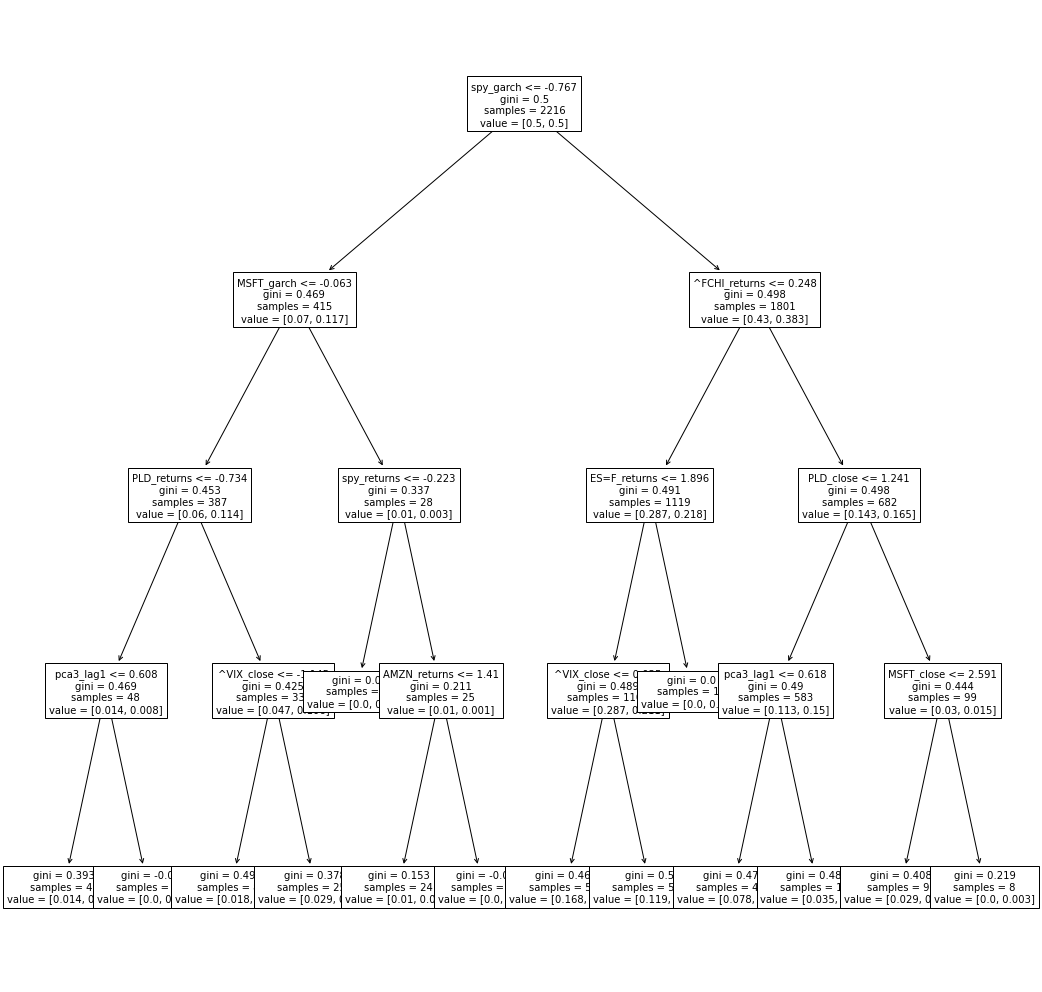

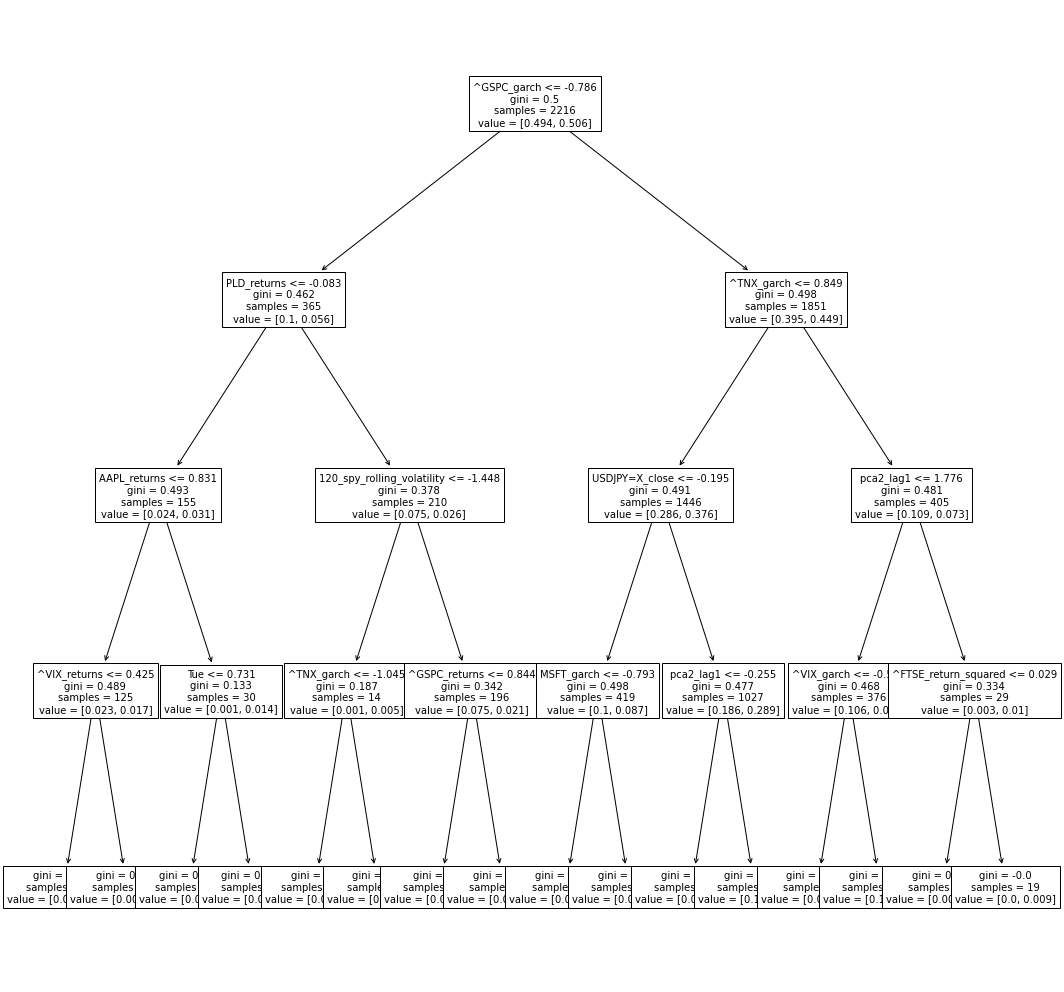

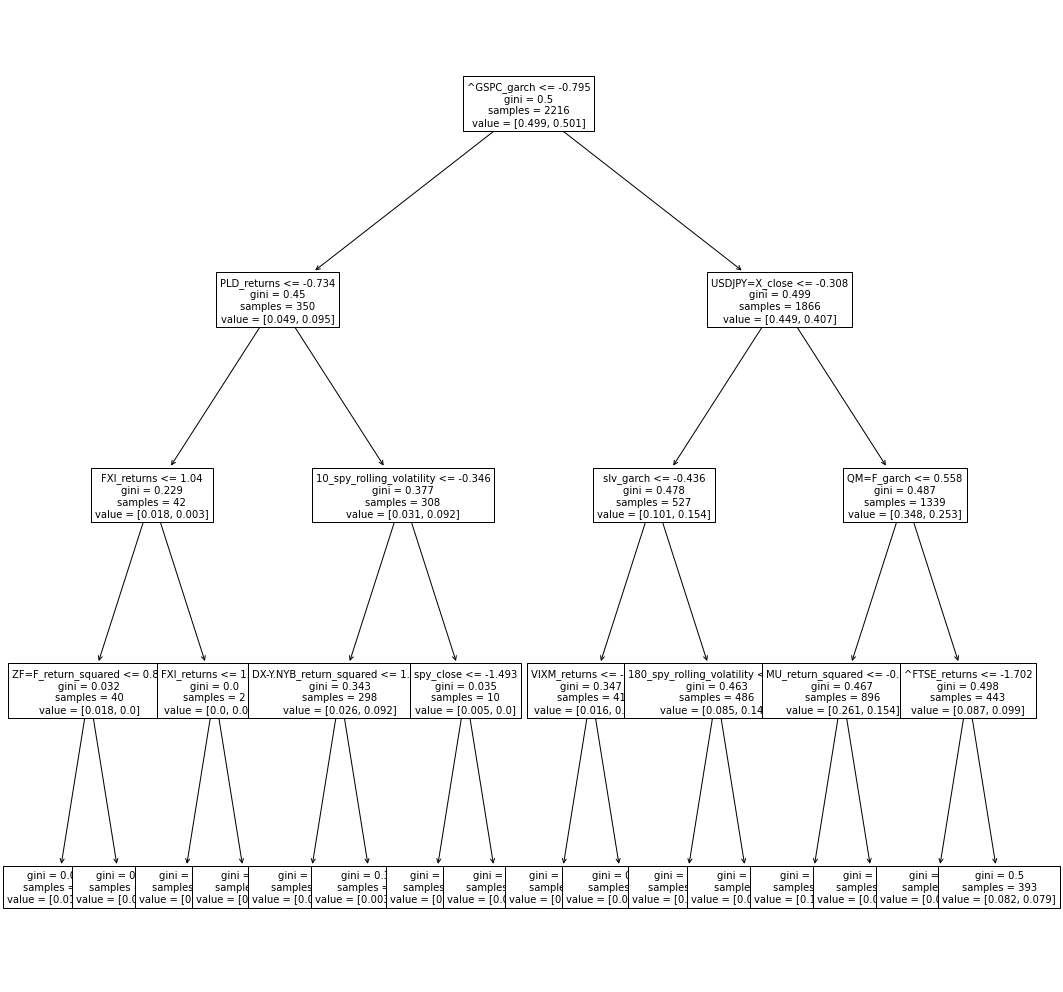

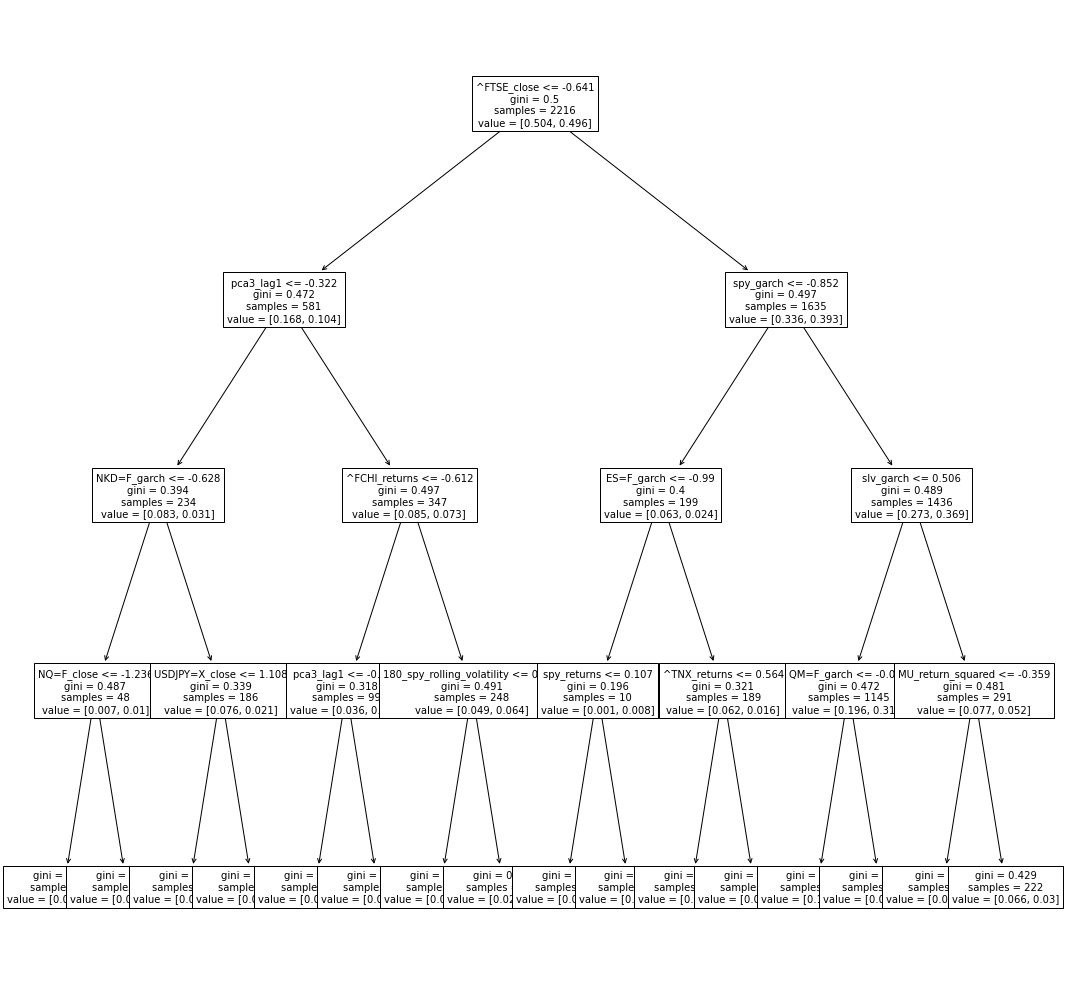

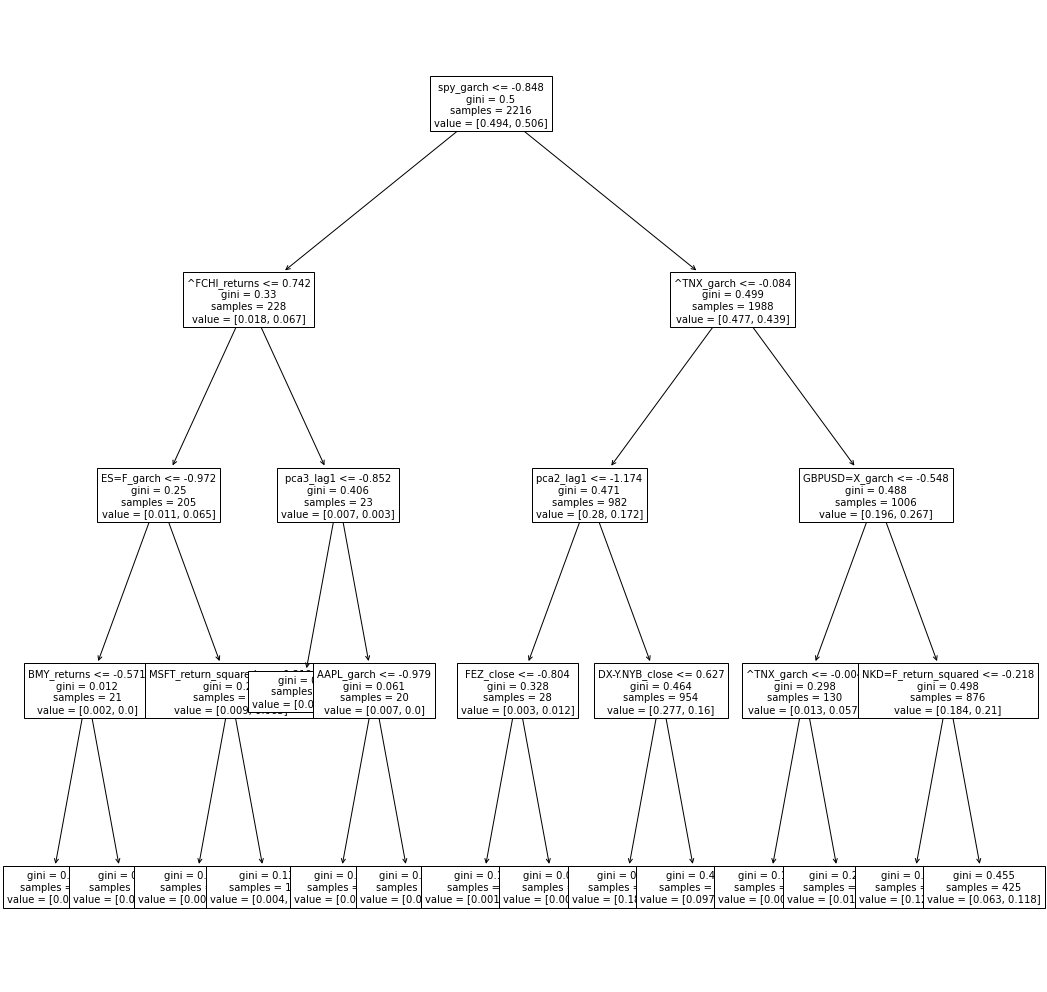

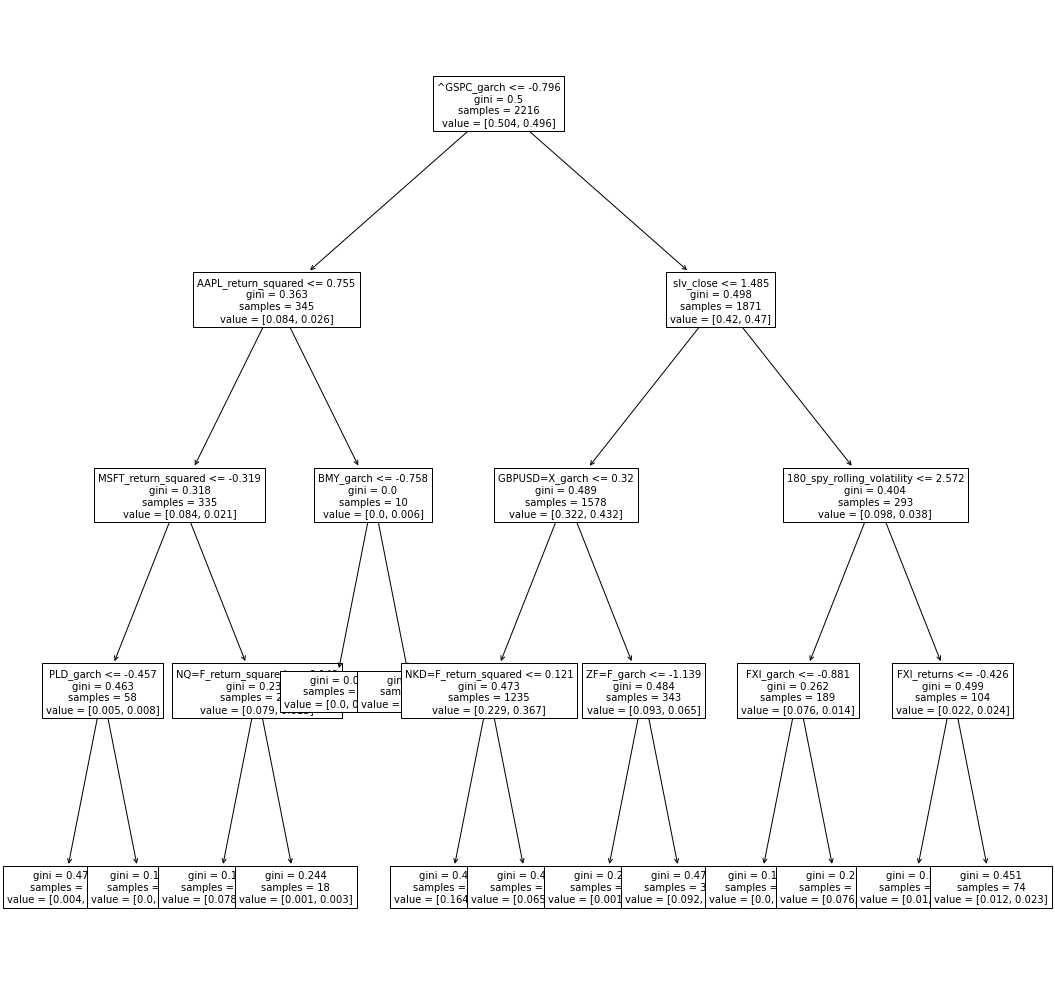

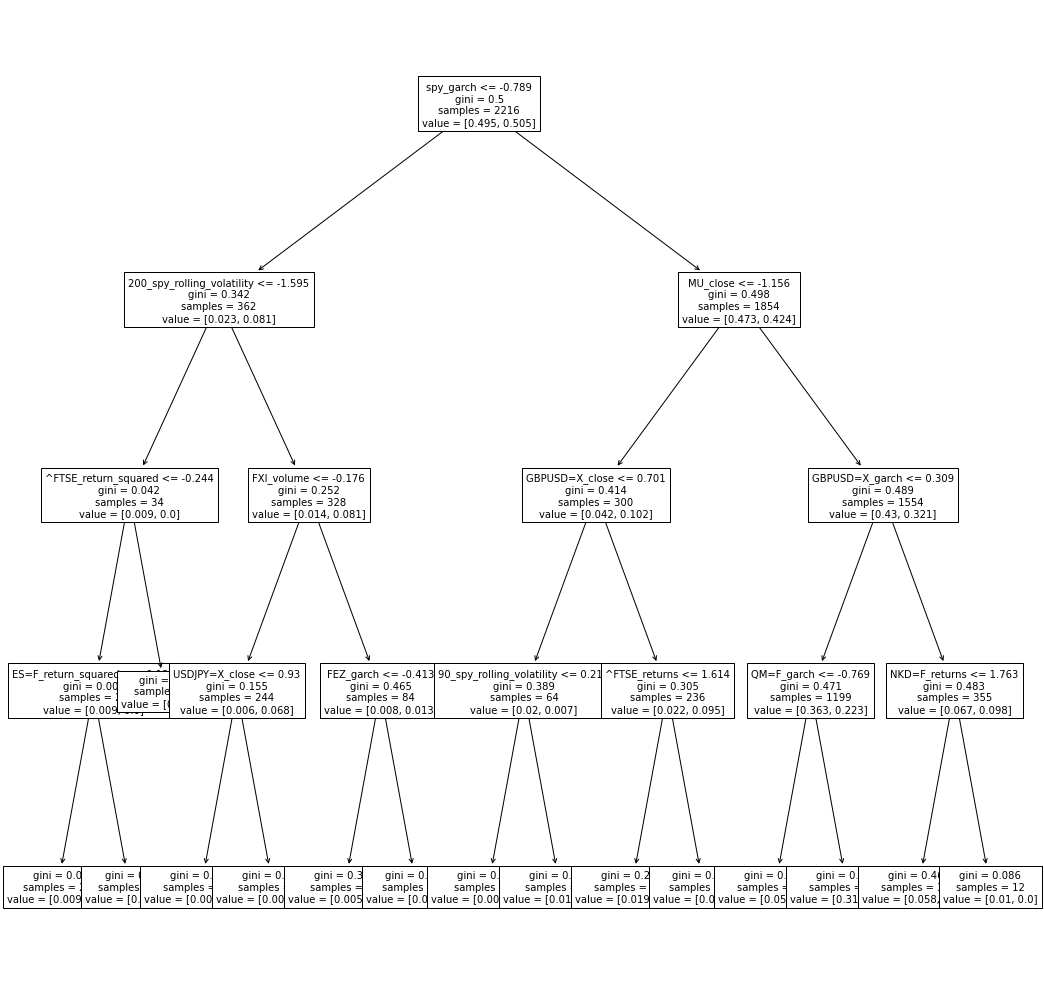

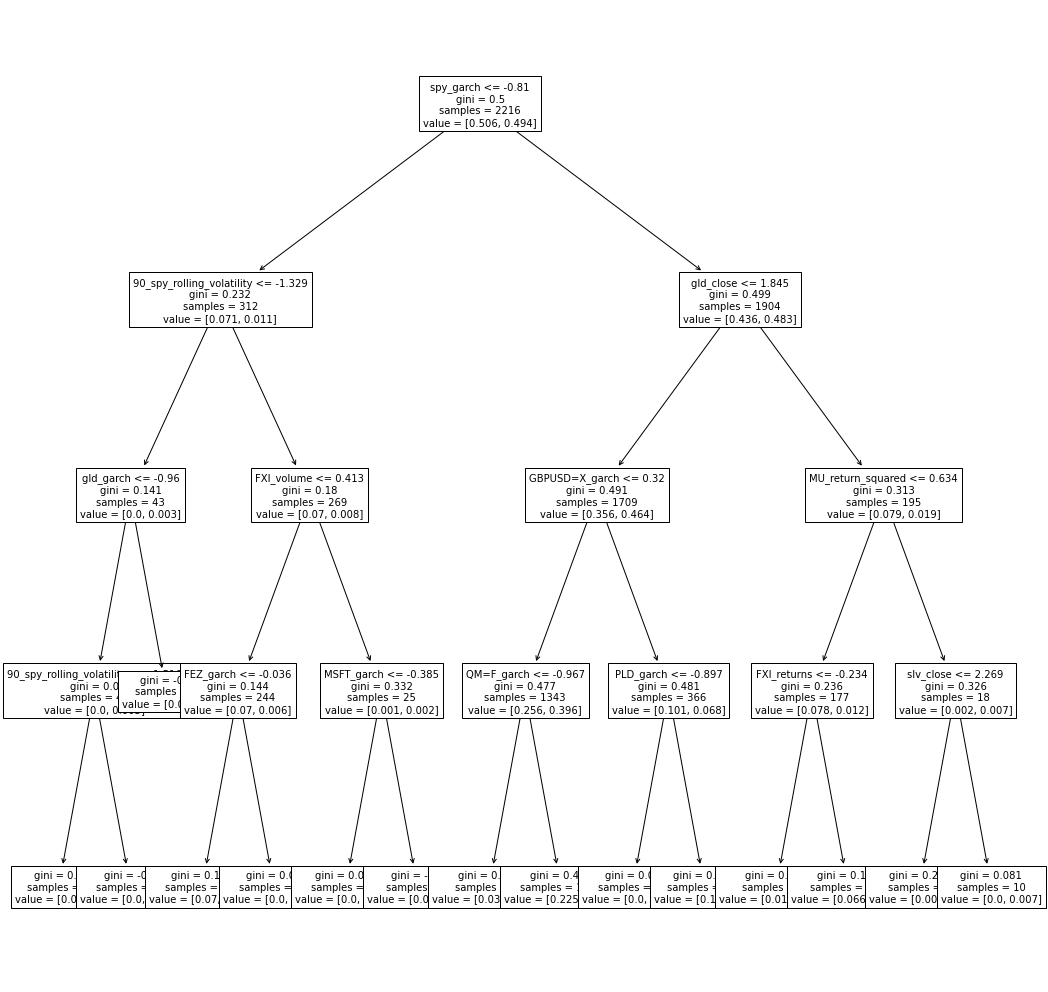

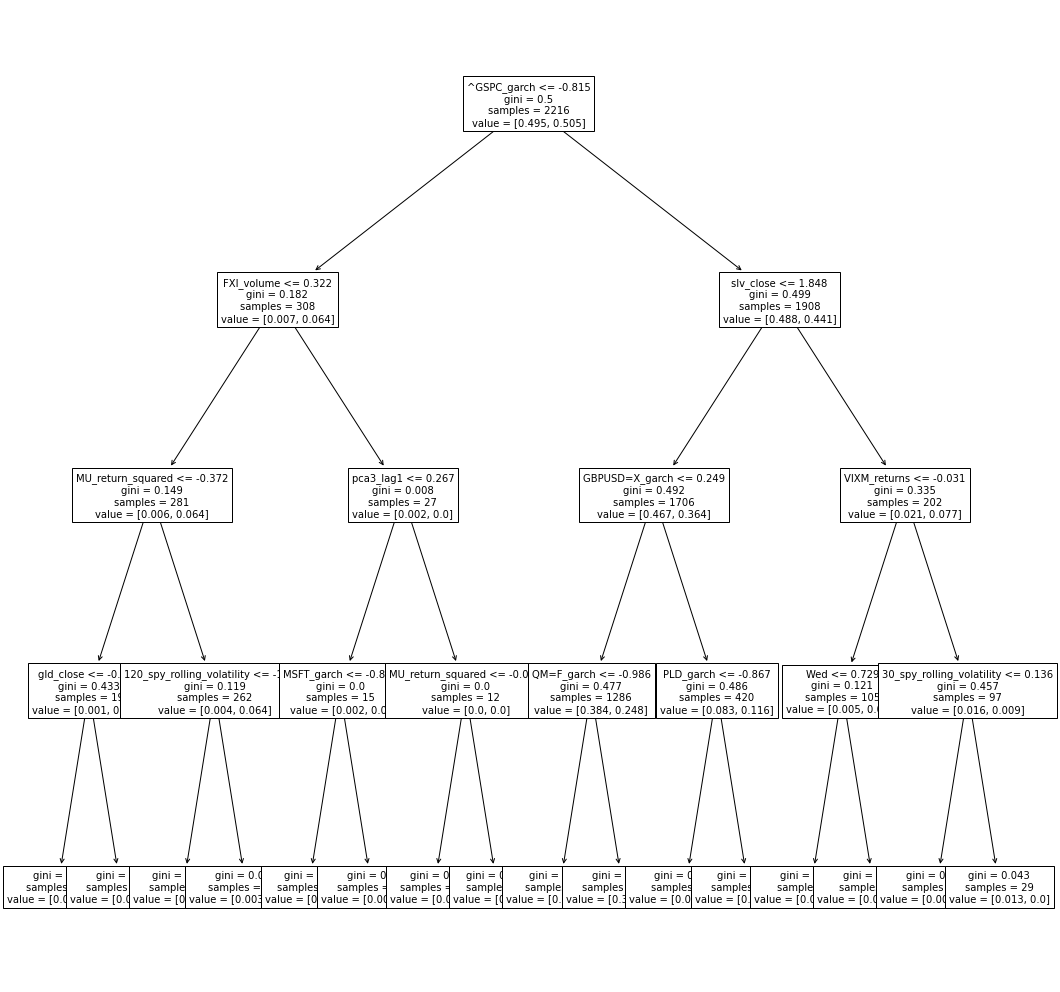

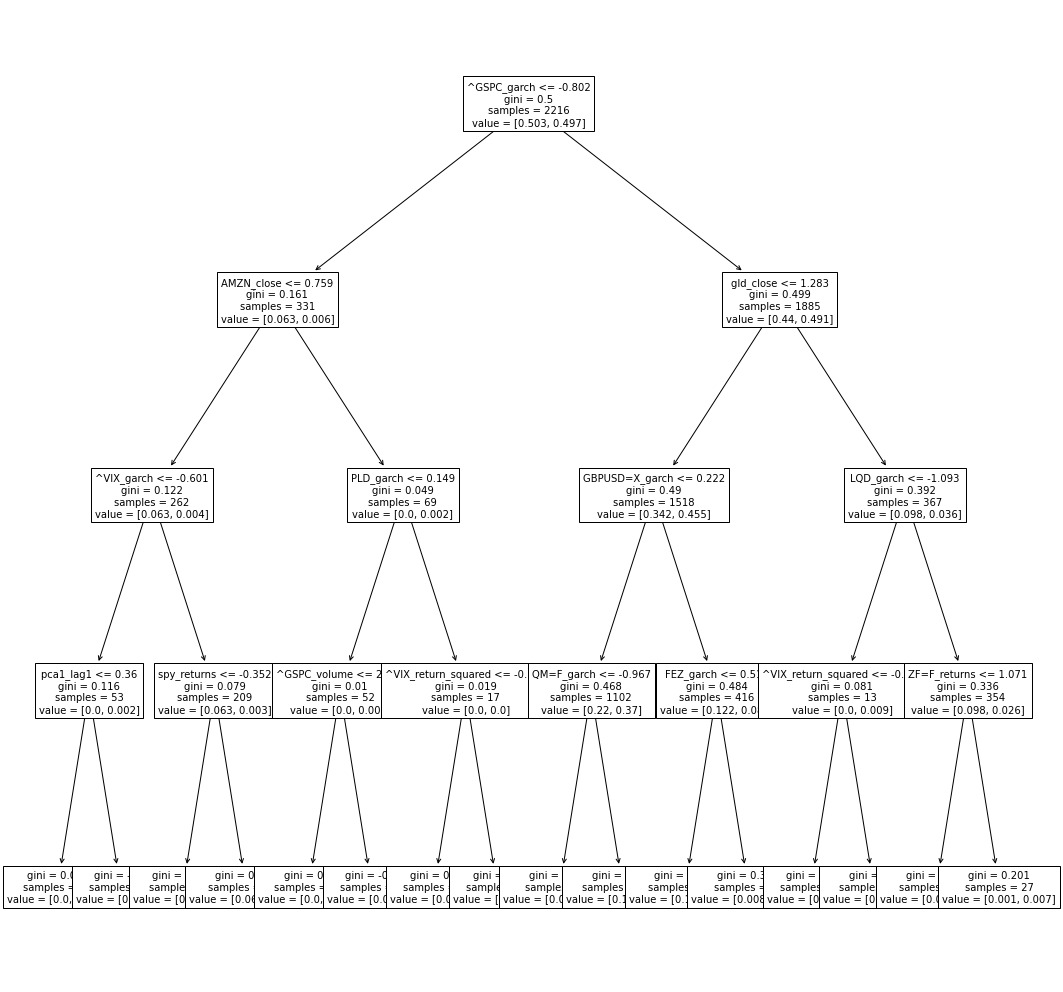

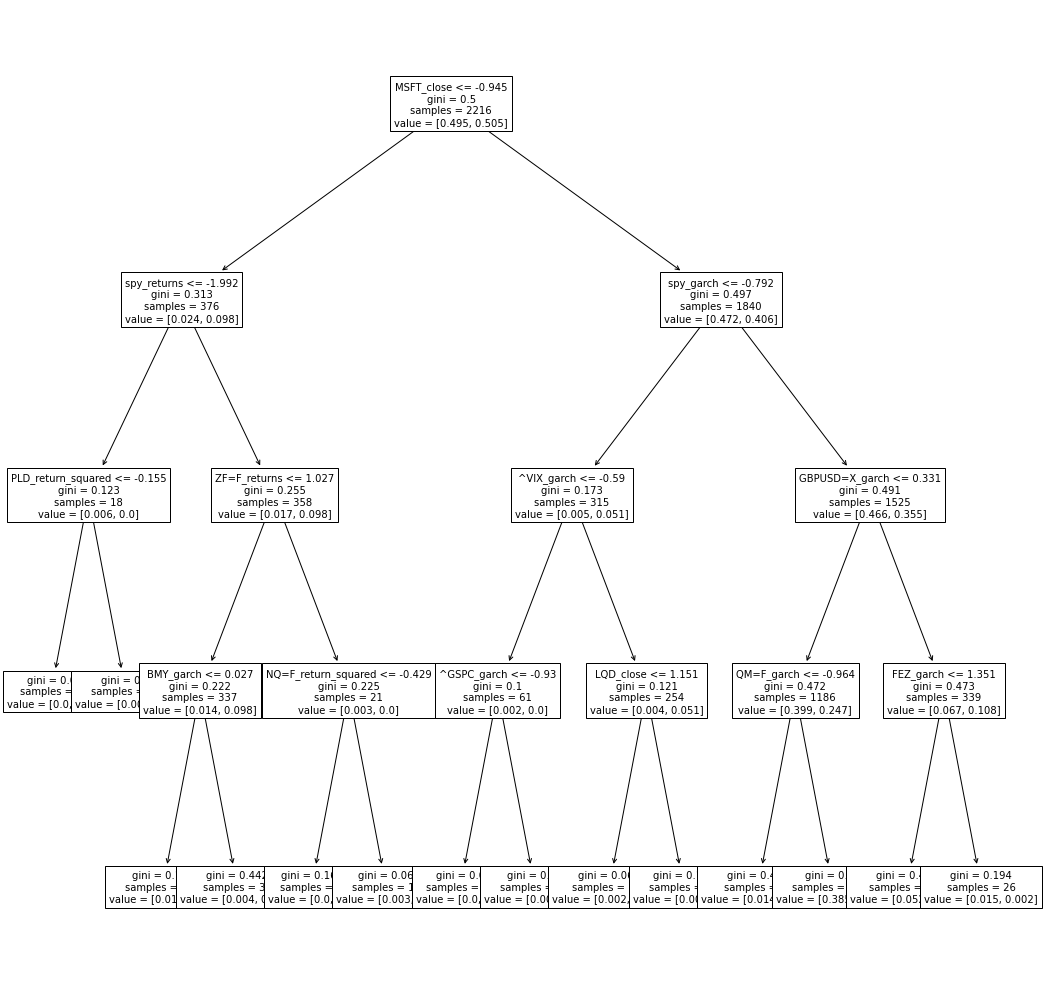

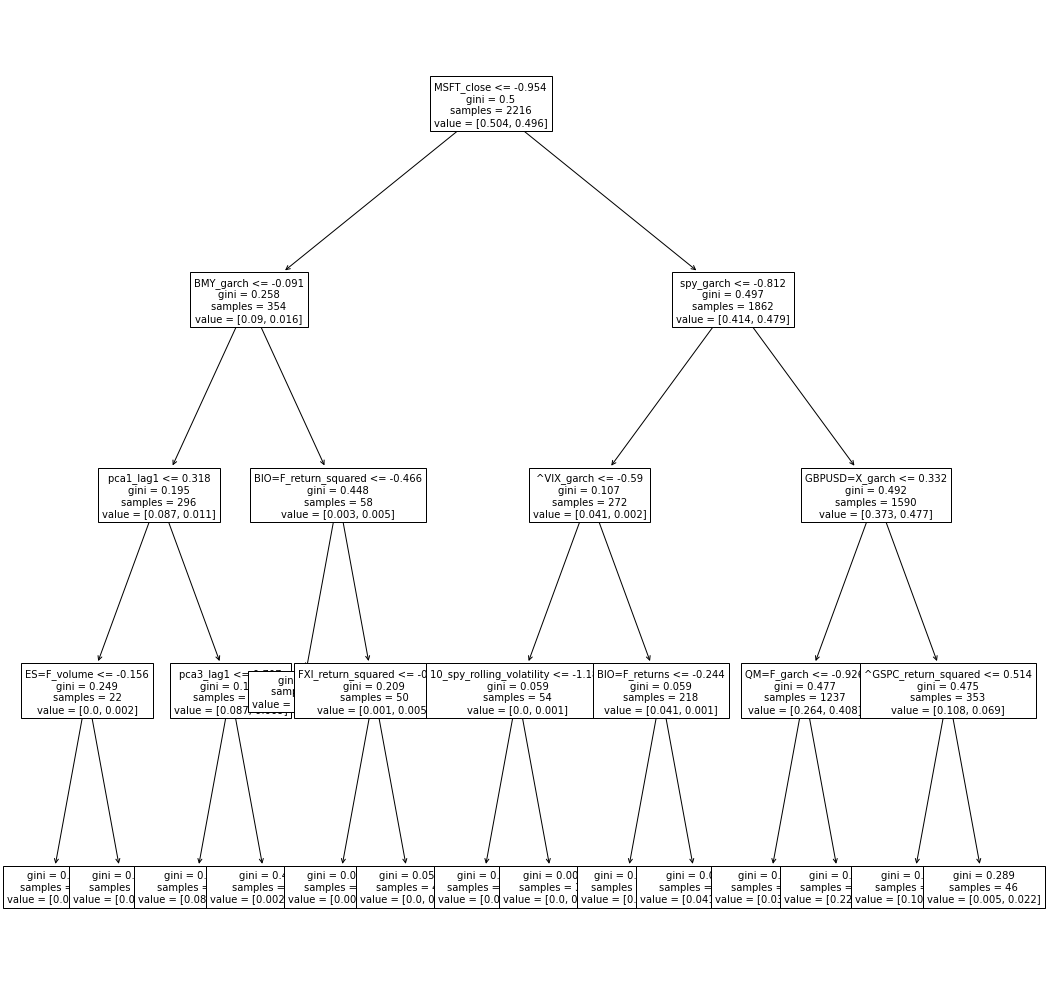

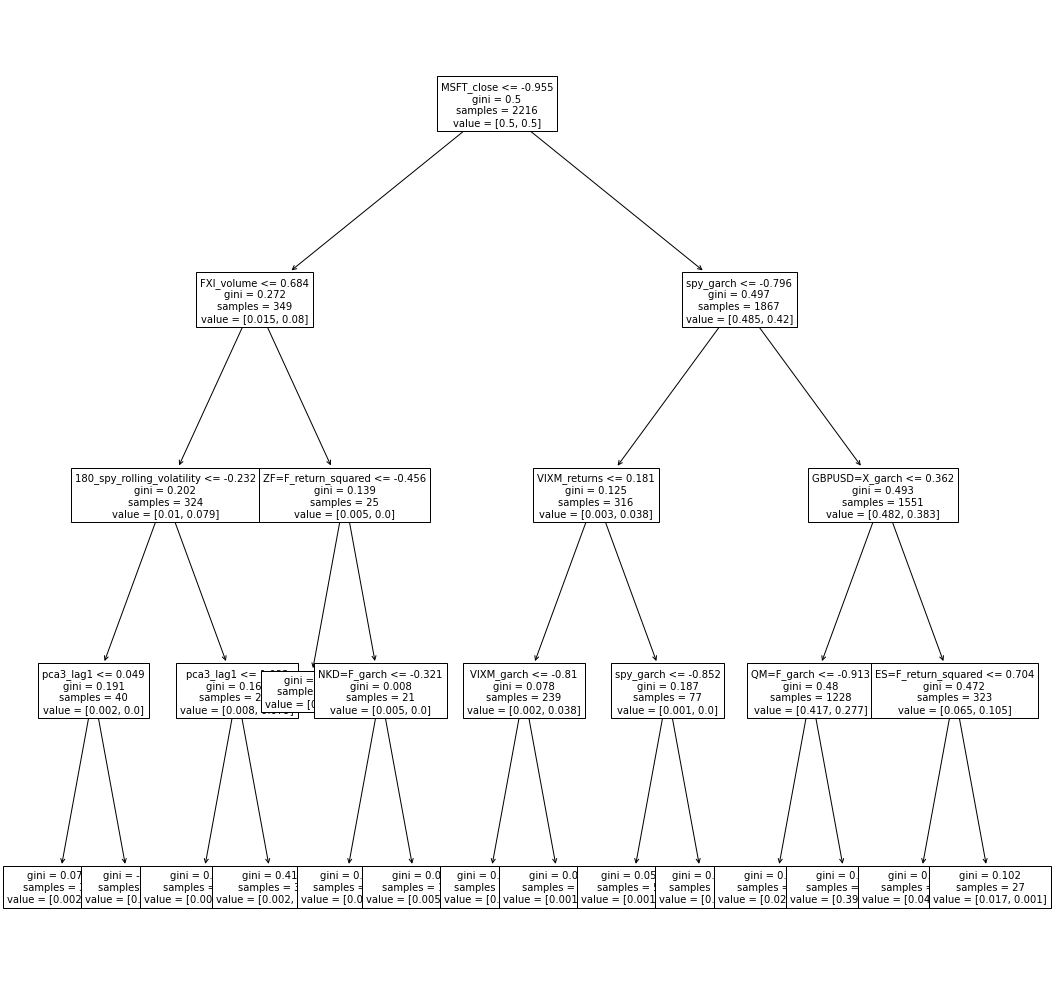

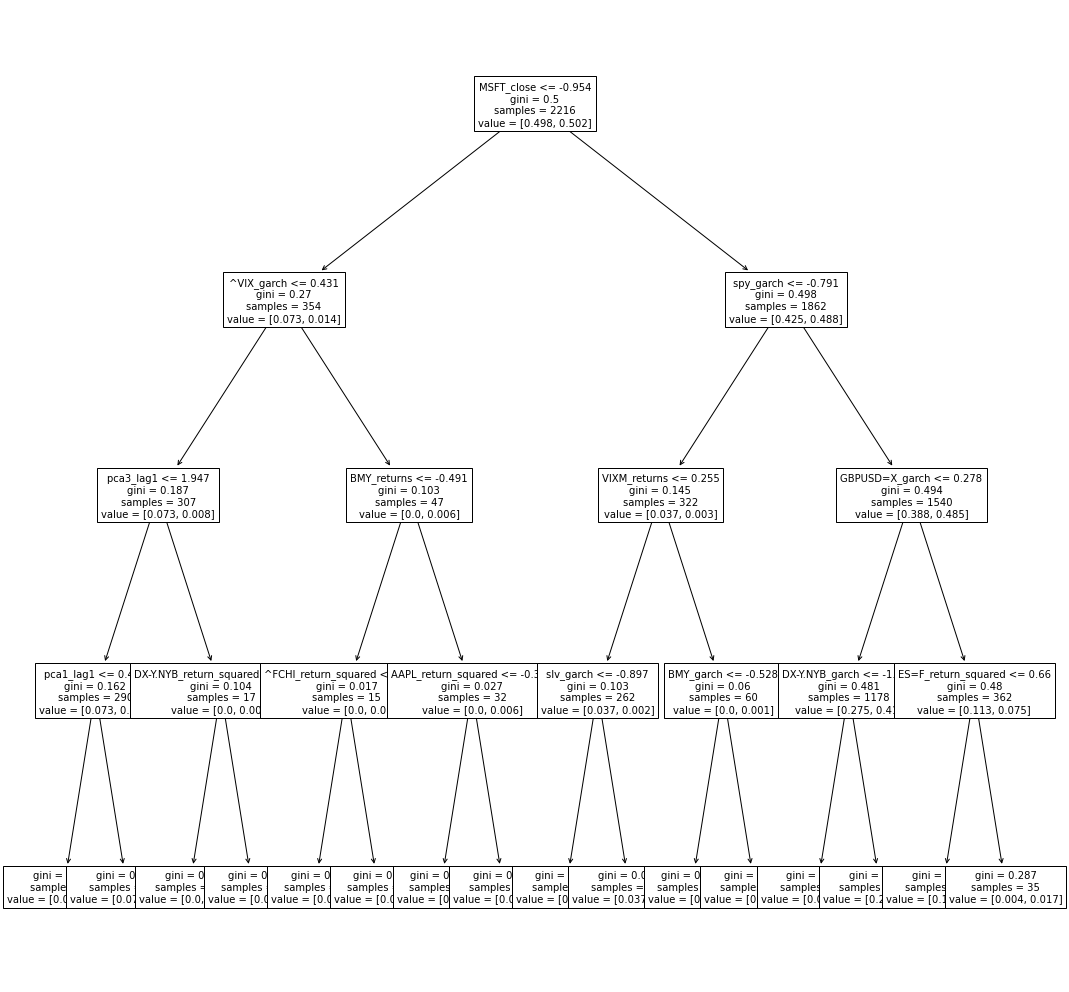

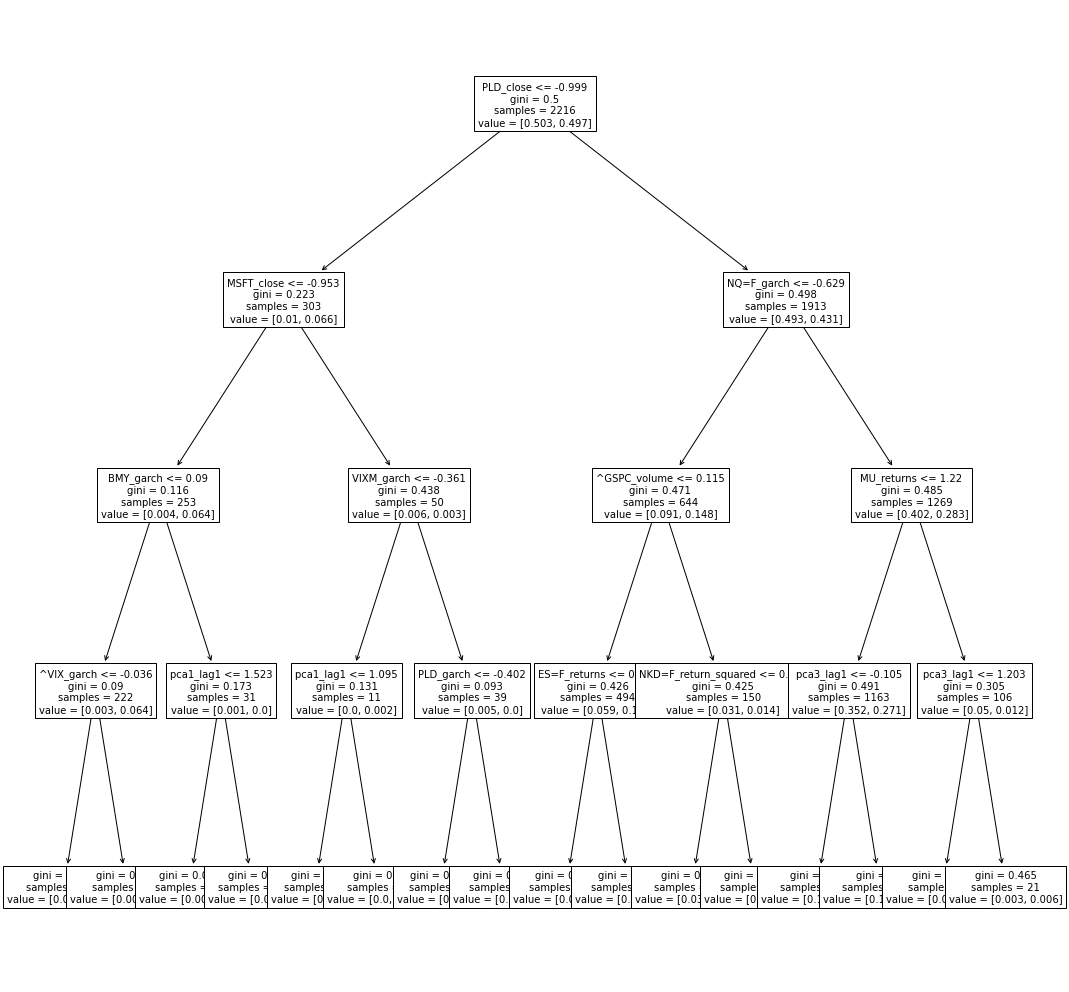

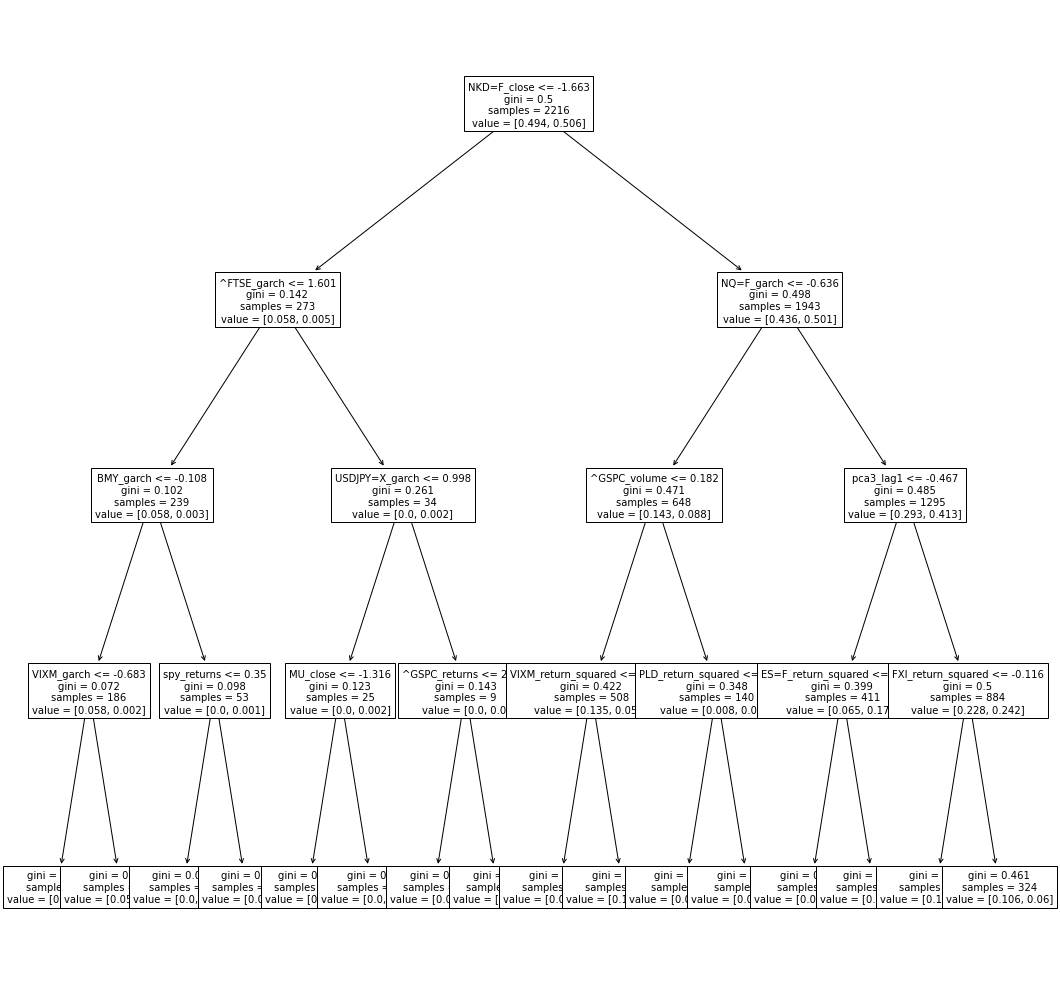

In [278]:
from sklearn import tree
#adaboost_model.estimators_
#tree.plot_tree(adaboost_model.estimators_[0],fontsize=10)

import matplotlib.pyplot as plt
# plot tree

for i in range(0,len(adaboost_model.estimators_)):
    plt.figure(figsize=(18,18))  # set plot size (denoted in inches)
    tree.plot_tree(adaboost_model.estimators_[i],fontsize=10, feature_names=X.columns, proportion=False)
    plt.show()

# Profitability Analysis
The large size of VIX returns would make a huge compounding effect if it were possible to bet on it and track its performance,.
As can be seen below, the average size of daily returns are around 5%, with returns that can get as large as 115% in one day. The median is 

In this section we will compare the results of betting on the model applying an imaginary strategy of betting at the open of the day, and close the bet at the end of the day. We will assume that the approximately the open level will be very similar than the close level of the previous day.

In [279]:
# VIX size of returns (in absolute value and %)
vixm_return_statistics=abs(100 * security_returns_df['VIXM']).describe()
display(vixm_return_statistics)

count    2642.000000
mean        5.191312
std         5.616817
min         0.000000
25%         1.491582
50%         3.656884
75%         6.935895
max        66.206395
Name: VIXM, dtype: float64

In [280]:

#y_train_df.index.min()
#y_train_df.index.max()

### In-sample analysis: Return on $1 invested on training data window

In [281]:
# Results comnparison

# Profitability on the train window
fit_train= adaboost_model.predict(X_train_scaled)
fit_train_df= pd.DataFrame(fit_train, index=X_train.index)

fit_train_df.hvplot()

y_train_df=pd.DataFrame(y_train, index=X_train.index)
y_train_df

vixm_returns_train_df=vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
vixm_returns_train_df = vixm_returns_train_df.loc[y_train_df.index]


results_train_df=pd.concat([vixm_returns_train_df, y_train_df, fit_train_df], axis=1)

results_train_df.columns=['VIXM Return', 'Correct Signal', 'Fit Signal']

predicted_return=results_train_df['VIXM Return']*results_train_df['Fit Signal']
max_return=results_train_df['VIXM Return']*results_train_df['Correct Signal']


results_train_df=pd.concat([results_train_df, predicted_return, max_return], axis=1)
results_train_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal', 'Fit Return', 'Max Return']


return_of_one_dollar_in_train_window_df=(1+results_train_df[['VIXM Return','Fit Return']]).cumprod()
return_of_one_dollar_in_train_window_df.columns=['VIXM_ROI', 'ROI Model (in sample)']

profitability_train_plot=return_of_one_dollar_in_train_window_df.hvplot(
                                             title="In-Sample Growth of $1 initial Investment in Daily Trade Strategy on VIX",
                                             ylabel="Dollars $" ,
                                             width=1000
 )

profitability_train_plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [282]:
y_train_df.index

DatetimeIndex(['2011-10-25', '2011-10-26', '2011-10-27', '2011-10-28',
               '2011-10-31', '2011-11-01', '2011-11-02', '2011-11-03',
               '2011-11-04', '2011-11-07',
               ...
               '2019-08-12', '2019-08-13', '2019-08-14', '2019-08-15',
               '2019-08-16', '2019-08-19', '2019-08-20', '2019-08-21',
               '2019-08-22', '2019-08-23'],
              dtype='datetime64[ns]', name='Date', length=1952, freq=None)

### Out-of--sample analysis: Return on $1 invested on training data window

In [283]:
# Results comnparison

# Profitability on the test window

# Out-of-sample Predictions 
prediction_test= adaboost_model.predict(X_test_scaled)
prediction_test_df= pd.DataFrame(prediction_test, index=X_test.index)

# Out-of-sample signals (1s or 0s) based on actual returns of the VIX
y_test_df=pd.DataFrame(y_test, index=X_test.index)
y_test_df

# VIXM returns in the test window
vixm_returns_df=vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

# Combination of VIXM Returns, signals and predictions
results_test_df = pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
results_test_df.columns = ['VIXM Return', 'Correct Signal', 'Predicted Signal']

# Predicted returns
predicted_return=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
max_return=results_test_df['VIXM Return']*results_test_df['Correct Signal']

# SPY as benchmark
spy_out_of_sample_period_returns=security_returns_component_df['spy'].loc[y_test_df.index.min():y_test_df.index.max()]

# DataFrame with out-of-sample results for comparison
results_test_df=pd.concat([results_test_df, predicted_return, max_return, spy_out_of_sample_period_returns], axis=1)
results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal', 'Predicted Return', "Max Return", "Benchmark: SPY"]

return_of_one_dollar_in_test_window_df=(1+results_test_df[['VIXM Return', 'Predicted Return', "Benchmark: SPY"]]).cumprod()
return_of_one_dollar_in_test_window_df.columns=['VIXM Cummulative return', ' Model Cummulative Return (out of sample)', 'Benchmark: SPY']


#Plot with out of sample return on a 1 dollar investment for the VIX, and the daily bet strategy

# Set plot and style options
profitability_test_plot=return_of_one_dollar_in_test_window_df.hvplot(
                         title='Out-Of-Sample Growth of $1 initial Investment in Daily Trade Strategy on VIXM',
                         ylabel= "Dollars $",
                         width=1000,
                         color=["red","green", "blue"]
                )

profitability_test_plot





:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [284]:
prediction_test_df.hvplot(width=1200, kind='bar')*(5*vixm_returns_df).hvplot(kind='bar', color=["green"])

:Overlay
   .Bars.I  :Bars   [Date]   (0)
   .Bars.II :Bars   [Date]   (VIXM_ret)

### Comments
0. The VIXM invest in VIX Futures in order to make profit.
1. The VIXM has massive positive returns in moments of crushes in the market, and tends to decay in time due to the rolling effect on its futures contracts. 
2. Due to the decay effect, VIXM can only be profitable for short term trades. Can not be a invest and hold strategy
3. Our algorithmic trading investment strategy on VIXM takes advantage of the good return in market crushes, and in addition allows to generate profit during bull markets.
4. The VIXCoin investment works like a buy and hold strategy, and offers an investment opportunity to diversify a portfolio to reduce risk.


In [285]:
# Graph with SPY as benchmark
#benchmark_spy_out_of_sample_period_df=(1+security_returns_component_df['spy'].loc[y_test_df.index.min():y_test_df.index.max()]).cumprod()
#benchmark_spy_out_of_sample_period_df.hvplot()

In [286]:
# Results in prediction of daily returns
min_return=threshold
results_test_for_plot_df=results_test_df[abs(results_test_df['VIXM Return'])>min_return]*100

results_test_for_plot_df.hvplot(
                    y=['VIXM Return', 'Predicted Return'],
                    title= "Out-of-sample predictions of VIXM return",
                    width=1000,
                    ylabel='Daily Return (%)'
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [287]:
#Histogram of returns out of sample
results_test_for_plot_df.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIXM returns predictions"
)

:NdOverlay   [Element]
   :Histogram   [Predicted Return]   (Predicted Return_count)

### Analysis of good and bad predictions

In [288]:
# Analysis of the good and bad out-of-sample predictions
good_predictions=results_test_df[results_test_df['Correct Signal']==results_test_df['Predicted Signal']]

bad_predictions=results_test_df[results_test_df['Correct Signal']!=results_test_df['Predicted Signal']]


In [289]:
good=good_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns of Good Predictions"
)

bad=bad_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns on Bad Predictions"
)
good+bad

:Layout
   .NdOverlay.I  :NdOverlay   [Element]
      :Histogram   [Predicted Return]   (Predicted Return_count)
   .NdOverlay.II :NdOverlay   [Element]
      :Histogram   [Predicted Return]   (Predicted Return_count)

### Observations
We see that the number of negative returns that are dismissed are similar to the ones avoided when returns are small. However, for large tailed negative returns, there are significantly many more that are avoided (9+6 =15) than the ones that are not avoided (3+1 = 4 )

In [290]:
# Good prediction statistics
good_predictions[['VIXM Return', 'Predicted Return']].describe()

VIXM Return  Predicted Return
count   340.000000        340.000000
mean     -0.010010          0.020432
std       0.076568          0.058760
min      -0.232466         -0.033758
25%      -0.048890         -0.000000
50%      -0.022349         -0.000000
75%       0.005421          0.004513
max       0.574773          0.574773

In [291]:
# Bad prediction statistics
bad_predictions[['VIXM Return', 'Predicted Return']].describe()

VIXM Return  Predicted Return
count   221.000000        221.000000
mean      0.008196         -0.021895
std       0.078373          0.034251
min      -0.149507         -0.149507
25%      -0.038404         -0.033408
50%       0.005425          0.000000
75%       0.039085          0.000000
max       0.501648          0.000000

In [292]:
# Box Plot predictions for good and bad predictions
good_pred=good_predictions['Predicted Return']
bad_pred =bad_predictions['Predicted Return']

predictions_comparison_df=pd.concat([good_predictions['Predicted Return'],bad_predictions['Predicted Return']], axis=1, ignore_index=True )*100
predictions_comparison_df.hvplot(kind='box',
                                height=800,
                                ylabel='Return (%)',
                                #clabel=['Good Predictions', 'Bad Predictions'],
                                cmap=['blue','red'],
                                title="Out-of-sample Good and Bad Returns Resulting from Model Predictions Box Plots")





#df = pd.DataFrame(np.random.randn(20), columns=['Value'])
#df['Source'] = ['Preds'] *10 +['Real'] * 10
#df['Item'] = ['item1'] *5 + ['item2']*5 + ['item1'] *5 + ['item2']*5
#df.hvplot.box(y='Value', by=['Item', 'Source'])

:BoxWhisker   [Variable]   (value)

# OUTPUTS FOR TUNNING

In [293]:
def prepare_features(XY, pca_components):
    XY_modified = XY.shift().dropna()
    y = XY_modified["Signal"].shift(-1)
    X = XY_modified
    pca = PCA(n_components = pca_components)
    principal_components = pca.fit_transform(X)
    
    pca_column_list = []
    for i in range(1, pca_components+1):
        pca_column_list.append(f"pca{i}")

    principal_components_train_test_df = pd.DataFrame(data = principal_components, columns = pca_column_list, index = XY_modified.index)
    X_pca_lag1 = create_pca_lag1(principal_components_train_test_df)
    X_pca_lag2 = create_pca_lag2(principal_components_train_test_df)
    X_pca_lag3 = create_pca_lag3(principal_components_train_test_df)
    X_pca_lag4 = create_pca_lag4(principal_components_train_test_df)
    X_pca_lag5 = create_pca_lag5(principal_components_train_test_df)
        
    X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5)
    X_pc = concatenate_pca_with_lags(principal_components_train_test_df, X_pc_lags)
    X, y = eliminate_nans_in_pca_data(X_pc, y)
    
    X_train, y_train, X_test, y_test = split_training_test_data(X, y)
    X_train_resampled, y_train_resampled = random_over_sample(X_train, y_train)
    X_train_scaled, X_test_scaled = standard_scale(X_train_resampled, X_test)
    #principal_components_train_test
    if parameter_tuning_mode == True:
        display(sum(pca.explained_variance_ratio_))
        display(principal_components_train_test_df.shape)
    return X_train_scaled, X_test_scaled, y_train_resampled, y_test

In [ ]:
if run_multiple_tuning_iterations == True: 
    for num_estimators in range (1,25, 1):
        for depth in range(1,5,1):
            for rate in range(1,20,2):
                #rate=10
                base = DecisionTreeClassifier(max_depth=depth)
                adaboost_model=AdaBoostClassifier(base_estimator=base, 
                                      n_estimators=num_estimators, 
                                      learning_rate= rate/10 )

                # Fit the model 
                adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)
                pred_adaboost= adaboost_model.predict(X_test_scaled)
                prediction_test_df= pd.DataFrame(pred_adaboost, index=X_test.index)
                
                #Calculate Peofitability
                # VIXM returns in the test window
                vixm_returns_df=vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
                vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

                # Combination of VIXM Returns, signals and predictions
                results_test_df=pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
                results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal']

                # Predicted returns (we don't use the correct signal, but the predicted signal)
                predicted_return_df=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
                predicted_return_df.columns=['Date','VIXM_Strategy_return']
                roi_strategy_factor = (1+predicted_return_df).cumprod()[-1]
                             
        
                # Use a classification report to evaluate the model using the predictions and testing data
                adaboost_report=classification_report(y_test, pred_adaboost)

                #if num_estimators % 10 == 0 and num_components == 88:
                #    print(f"components {num_components} esimators {num_estimators}")
                #    print(f"f1 score 0 {f1_score(y_test, pred_adaboost, pos_label=0)} f1 score 1 {f1_score(y_test, pred_adaboost, pos_label=1)}")
                #    print(f"accuracy {accuracy_score(y_test, pred_adaboost)}")
                #    print(adaboost_report)
                f1_score_1 = f1_score(y_test, pred_adaboost, pos_label=1)
                f1_score_0 = f1_score(y_test, pred_adaboost, pos_label=0)
                recall_score_1 = recall_score(y_test, pred_adaboost, pos_label=1)
                recall_score_0 = recall_score(y_test, pred_adaboost, pos_label=0)
                accuracy_score_model = accuracy_score(y_test, pred_adaboost)
                if  accuracy_score_model >= .40 and f1_score_1 >= .40 and f1_score_0 >= .40 and recall_score_1 >= .40 and recall_score_0 >= .40 and roi_strategy_factor>1 :
                    print(f"estimators {num_estimators}, max tree deph: {depth},learning_rate:{rate/10}, growth of one dollar investment:{roi_strategy_factor}")
                    # print(f"variance explained {sum(pca.explained_variance_ratio_)}")
                    # Print the classification report
                    print("         AdaBoost Classification Report")
                    print(adaboost_report)
                print(f"Trying deph {depth}, n_estimators {num_estimators}, learning rate {rate/10}")

Trying deph 1, n_estimators 1, learning rate 0.1
Trying deph 1, n_estimators 1, learning rate 0.3
Trying deph 1, n_estimators 1, learning rate 0.5
Trying deph 1, n_estimators 1, learning rate 0.7
Trying deph 1, n_estimators 1, learning rate 0.9
Trying deph 1, n_estimators 1, learning rate 1.1
Trying deph 1, n_estimators 1, learning rate 1.3
Trying deph 1, n_estimators 1, learning rate 1.5
Trying deph 1, n_estimators 1, learning rate 1.7
Trying deph 1, n_estimators 1, learning rate 1.9
Trying deph 2, n_estimators 1, learning rate 0.1
Trying deph 2, n_estimators 1, learning rate 0.3
Trying deph 2, n_estimators 1, learning rate 0.5
Trying deph 2, n_estimators 1, learning rate 0.7
Trying deph 2, n_estimators 1, learning rate 0.9
Trying deph 2, n_estimators 1, learning rate 1.1
Trying deph 2, n_estimators 1, learning rate 1.3
Trying deph 2, n_estimators 1, learning rate 1.5
Trying deph 2, n_estimators 1, learning rate 1.7
Trying deph 2, n_estimators 1, learning rate 1.9
Trying deph 3, n_est

In [ ]:
# Number of estimators? 
if run_multiple_tuning_iterations == True:
    for n in range (30,200, 5):
        # Instance AdaBoost
        # Initiate the model instance
        adaboost_model=AdaBoostClassifier(n_estimators=n)

        # Fit the model 
        adaboost_model =adaboost_model.fit(X_train_scaled, y_train)
        pred_adaboost=adaboost_model.predict(X_test_scaled)
        print (n)
        # Use a classification report to evaluate the model using the predictions and testing data
        adaboost_report=classification_report(y_test, pred_adaboost)

        # Print the classification report
        print("         AdaBoost Classification Report")
        print(adaboost_report)
#120 highest 1-recall
#150 good overall accuracy, but lower 1-recall


#### Future enhancements:

* Clear variables that are not important
* Try increasing the deph of the AdaBoost model
* Include more features
* X8: use a function to generate the rolling volatilities, and set the number on the column name